In [1]:
# --- CONFIG (auto-inserted 2025-10-23T14:45:21.618535Z) ---
# Este bloque no altera el modelo ni los resultados; solo fija rutas/semilla y muestra versiones.
import os, random, sys
from pathlib import Path
import numpy as np

SEED = 42  # No cambia hiperparámetros; úsalo solo si necesitas aleatoriedad consistente
os.environ.setdefault("PYTHONHASHSEED", str(SEED))
np.random.seed(SEED)
try:
    import torch
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
except Exception:
    pass

# Rutas recomendadas
DATA_DIR = Path(".")
DATASET_PATH = DATA_DIR / "bank-additional_bank-additional-full.csv"  # Asegúrate de que el CSV esté en el mismo directorio del notebook

# Mostrar versiones (útil para reproducibilidad)
def _show_versions():
    pkgs = ["python", "pandas", "numpy", "scikit-learn", "imbalanced-learn", "matplotlib", "seaborn", "scipy"]
    vers = {"python": sys.version.split()[0]}
    for pkg in pkgs[1:]:
        try:
            mod = __import__(pkg.replace("-", "_").replace("scikit-learn","sklearn"))
            vers[pkg] = getattr(mod, "__version__", "unknown")
        except Exception:
            vers[pkg] = "not installed"
    print("Versions:", vers)

_show_versions()
# --- FIN CONFIG ---


Versions: {'python': '3.12.7', 'pandas': '2.2.2', 'numpy': '1.26.4', 'scikit-learn': 'not installed', 'imbalanced-learn': 'not installed', 'matplotlib': '3.9.2', 'seaborn': '0.13.2', 'scipy': '1.13.1'}


In [2]:
# Chequeo rápido de dataset
from pathlib import Path
p = Path("bank-additional_bank-additional-full.csv")
assert p.exists(), f"No se encontró el dataset: {p.resolve()}. Ponlo junto al notebook."
print("OK: dataset encontrado:", p)

AssertionError: No se encontró el dataset: /Users/ramitafrita/Documents/Master Nuclio Data Analytics/TFM/TFM FIXED/bank-additional_bank-additional-full.csv. Ponlo junto al notebook.

## 📑 Introducción

Este Notebook forma parte del **Trabajo Final de Data Analytics** aplicado a una empresa Fintech.  

El objetivo es **analizar los datos de campañas de marketing telefónicas** realizadas entre 2018 y 2020, con el fin de identificar patrones, factores de éxito y variables clave que influyen en la contratación de un depósito a plazo fijo.  

En este documento se desarrollan los siguientes pasos iniciales del proyecto:  

1. **Tratamiento y exploración inicial de los datos**  
   - Revisión de calidad del dataset.  
   - Identificación de valores problemáticos (nulos, duplicados, categorías desconocidas).  
   - Creación de variables derivadas para enriquecer el análisis.  

2. **Análisis exploratorio de variables (EDA)**  
   - Estudio de las variables demográficas, económicas y de contacto.  
   - Evaluación de la respuesta de los clientes según diferentes segmentos.  

3. **Cruce de variables clave**  
   - Identificación de interacciones relevantes entre características del cliente y la respuesta a la campaña.  

4. **Modelo predictivo de conversión**
   - Construcción de modelos de predicción para estimar la probabilidad de conversión de un cliente (`y = yes`).  

El propósito de este análisis exploratorio es **dejar preparado el terreno para las siguientes fases**:  
- Construcción de un modelo predictivo que estime la probabilidad de conversión.  
- Diseño de un dashboard ejecutivo con los principales KPIs de las campañas.  


# 1. Tratamiento y exploración inicial de los datos

### 1.1 Importación de librerías

In [ ]:
#!pip install pandas as pd
#!pip install matplotlib as plt
#!pip install plotly as px
#!pip install seaborn as sns
#!pip install fuzzywuzzy as fw
#!pip install scipy as sp
#!pip install imbalanced-learn

In [ ]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Expresiones regulares
import re
from fuzzywuzzy import process

import warnings
warnings.filterwarnings('ignore')

## 1.2 Carga de datos

In [ ]:
import os
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "bank-additional_bank-additional-full.csv")

In [ ]:
url = DATA_PATH
df_tfm_inicial = pd.read_csv(url, sep=';')

## 1.3 Exploración inicial

### - Funciones

In [ ]:
def check_df(df, tipo=''):
    if tipo == 'simple':
        print("¿Cuántas filas y columnas hay en el conjunto de datos?")
        num_filas, num_columnas = df.shape
        print("\tHay {:,} filas y {:,} columnas.".format(num_filas, num_columnas))

        print("¿Cuáles son las primeras dos filas del conjunto de datos?")
        display(df.head(2))
        print('\n########################################################################################')
    else:
        print("¿Cuántas filas y columnas hay en el conjunto de datos?")
        num_filas, num_columnas = df.shape
        print("\tHay {:,} filas y {:,} columnas.".format(num_filas, num_columnas))
        print('\n########################################################################################')

        print("¿Cuáles son las primeras cinco filas del conjunto de datos?")
        display(df.head())
        print('\n########################################################################################')

        print("¿Cuáles son las últimas cinco filas del conjunto de datos?")
        display(df.tail())
        print('\n########################################################################################')

        print("¿Cómo puedes obtener una muestra aleatoria de filas del conjunto de datos?")
        display(df.sample(n = 5))
        print('\n########################################################################################')

        print("¿Cuáles son las columnas del conjunto de datos? ¿Cuál es el tipo de datos de cada columna?")
        print(df.dtypes)
        print('\n########################################################################################')

        print("¿Cuántas columnas hay de cada tipo de datos?")
        print(df.dtypes.value_counts())
        print('\n########################################################################################')

        print("¿Cuáles son las variables numéricas?")
        df_numericas = df.select_dtypes(include = 'number')
        columnas_numericas = list(df_numericas.columns)
        print(columnas_numericas)
        print('\n########################################################################################')

        print("¿Cuáles son las variables categóricas?")
        df_categoricas = df.select_dtypes(include = 'object')
        columnas_categoricas = list(df_categoricas.columns)
        print(columnas_categoricas)
        print('\n########################################################################################')

        print("¿Cuántos valores únicos tiene cada columna?")
        print(df.nunique())
        print('\n########################################################################################')

        if len(columnas_numericas)>0:
            print("¿Cuáles son las estadísticas descriptivas básicas de las columnas numéricas?")
            display(df.describe(include = 'number'))
            print('\n########################################################################################')

        if len(columnas_categoricas)>0:
            print("¿Cuáles son las estadísticas descriptivas básicas de las columnas categóricas?")
            display(df.describe(include = 'object'))

In [ ]:
def identificacion_valores_problem(df, columnas=[]):
    print('###################################################################################')
    print('3.1.1. Proporción de NULOS en cada una de las columnas del conjunto de datos:')
    print(round((df.isnull().sum()/len(df))*100, 2).sort_values(ascending= False))
    print('###################################################################################')
    print(f'3.1.2. Número de DUPLICADOS totales: {df.duplicated().sum()}')
    print('###################################################################################')
    if len(columnas) > 0:
        print(f'3.1.2. Número de DUPLICADOS parciales según las columnas {columnas}: {df.duplicated(subset=columnas).sum()}')
        print('###################################################################################')
    df_numericas = df.select_dtypes(include = 'number')
    columnas_numericas = list(df_numericas.columns)
    if len(columnas_numericas) > 0:
        print('3.1.3. Columnas numéricas con OUTLIERS')
        for var in columnas_numericas:
            Q1 = df[var].quantile(0.25)
            Q3 = df[var].quantile(0.75)
            limite_inferior = Q1 - 1.5 * (Q3 - Q1)
            limite_superior = Q3 + 1.5 * (Q3 - Q1)
            outliers = df[(df[var] < limite_inferior) | (df[var] > limite_superior)]
            print(f'Número de outliers en la columna "{var}": {outliers.shape[0]}')
        print('###################################################################################')

In [ ]:
def deteccion_outliers (df, columna):
    # Calcular Q1, Q3 e IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites inferior y superior para detectar outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print(f"Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:")
    print(f"\t - Límite inferior (considerado extremadamente bajo): {limite_inferior:.2f}")
    print(f"\t - Límite superior (considerado extremadamente alto): {limite_superior:.2f}")

    # Identificar los outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

    print(f'Número de outliers en la columna "{columna}": {outliers.shape[0]}')
    return outliers

In [ ]:
def imputacion_nulos (df, variable):
    # media
    media = df[variable].mean()
    df[variable + '_media'] = df[variable].fillna(media)

    # mediana
    mediana = df[variable].median()
    df[variable + '_mediana'] = df[variable].fillna(mediana)

    # random
    valores_no_nulos = df[variable].dropna().values
    df[variable + '_random'] = df[variable].apply(lambda x: np.random.choice(valores_no_nulos) if pd.isna(x) else x)
    return df, [variable, variable + '_media', variable + '_mediana', variable + '_random']

### - Check inicial

In [ ]:
check_df(df_tfm_inicial)

¿Cuántas filas y columnas hay en el conjunto de datos?
	Hay 41,188 filas y 21 columnas.

########################################################################################
¿Cuáles son las primeras cinco filas del conjunto de datos?


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no



########################################################################################
¿Cuáles son las últimas cinco filas del conjunto de datos?


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no



########################################################################################
¿Cómo puedes obtener una muestra aleatoria de filas del conjunto de datos?


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
35333,37,technician,single,professional.course,no,yes,no,cellular,may,fri,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
40381,47,admin.,married,university.degree,no,no,no,cellular,aug,wed,...,1,4,2,success,-1.7,94.027,-38.3,0.900,4991.6,yes
19449,30,technician,single,university.degree,no,yes,yes,cellular,aug,thu,...,3,999,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1,yes
6268,26,services,single,basic.9y,no,yes,yes,telephone,may,tue,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
31099,39,blue-collar,married,basic.9y,unknown,no,yes,cellular,may,wed,...,3,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1,no



########################################################################################
¿Cuáles son las columnas del conjunto de datos? ¿Cuál es el tipo de datos de cada columna?
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

########################################################################################
¿Cuántas columnas hay de cada tipo de datos?
object     11
int64       5
float64     5
Name: count, dtype: int64

#######################################################

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000



########################################################################################
¿Cuáles son las estadísticas descriptivas básicas de las columnas categóricas?


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


### - Detección de nulos

In [ ]:
identificacion_valores_problem(df_tfm_inicial, columnas = df_tfm_inicial.columns[0:])

###################################################################################
3.1.1. Proporción de NULOS en cada una de las columnas del conjunto de datos:
age               0.0
campaign          0.0
nr.employed       0.0
euribor3m         0.0
cons.conf.idx     0.0
cons.price.idx    0.0
emp.var.rate      0.0
poutcome          0.0
previous          0.0
pdays             0.0
duration          0.0
job               0.0
day_of_week       0.0
month             0.0
contact           0.0
loan              0.0
housing           0.0
default           0.0
education         0.0
marital           0.0
y                 0.0
dtype: float64
###################################################################################
3.1.2. Número de DUPLICADOS totales: 12
###################################################################################
3.1.2. Número de DUPLICADOS parciales según las columnas Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'mo

No hay valores nulos, por lo que no usaremos la función imputacion_nulos()

### - Detectar y eliminar filas duplicadas

In [ ]:
# Dejo el codigo de los duplicados por si a caso
df_tfm_inicial.duplicated().sum()

np.int64(12)

In [ ]:
## Dejo el codigo de duplicados por columas (elegir columnas)
# df_tfm_inicial.iloc[:, 3:].duplicated().sum()

# Esto no se si tiene sentido, igual para la duración de llamada, paro aun así puede ser que coincida. 

In [ ]:
# Eliminar filas duplicadas del dataframe original
df_tfm_sinduplicados = df_tfm_inicial.drop_duplicates()

# Mostrar información para verificar que el dataset está limpio
print("Resumen de limpieza de duplicados:")
print(f"→ Número de filas en el dataframe original: {df_tfm_inicial.shape[0]}")
print(f"→ Número de filas después de eliminar duplicados: {df_tfm_sinduplicados.shape[0]}")
print(f"→ Total de filas eliminadas: {df_tfm_inicial.shape[0] - df_tfm_sinduplicados.shape[0]}")

Resumen de limpieza de duplicados:
→ Número de filas en el dataframe original: 41188
→ Número de filas después de eliminar duplicados: 41176
→ Total de filas eliminadas: 12


In [ ]:
df_tfm_sinduplicados.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32074,38,admin.,single,unknown,no,yes,no,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
13655,29,blue-collar,single,basic.9y,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
5963,41,services,married,university.degree,no,yes,no,telephone,may,tue,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
21844,29,admin.,single,university.degree,no,yes,no,cellular,aug,wed,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
36713,29,student,single,professional.course,no,no,no,cellular,jun,fri,...,2,999,0,nonexistent,-2.9,92.963,-40.8,1.268,5076.2,no
9888,45,blue-collar,married,basic.6y,unknown,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
15102,51,blue-collar,married,basic.4y,unknown,yes,no,cellular,jul,thu,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
35537,30,technician,single,university.degree,no,no,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
15650,26,admin.,married,high.school,no,yes,no,cellular,jul,mon,...,4,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no
4334,42,admin.,married,university.degree,unknown,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no


### - Tratamiento de outliers

In [ ]:
# deteccion_outliers(df_tfm_sinduplicados,)

# PENDIENTE: GUILLE

### - Revisión de la columna default: Unknowns

In [ ]:
# Filtrar clientes con 'unknown' en la columna 'default'
clientes_unknown = df_tfm_sinduplicados[df_tfm_sinduplicados['default'] == 'unknown']
# Mostrar algunos ejemplos
clientes_unknown.sample(15)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
33071,46,technician,divorced,professional.course,unknown,no,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no
23143,48,services,married,basic.4y,unknown,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
21757,40,admin.,divorced,university.degree,unknown,yes,no,cellular,aug,tue,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
3387,27,blue-collar,married,basic.4y,unknown,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
11580,48,blue-collar,married,basic.9y,unknown,no,no,telephone,jun,fri,...,10,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
10248,40,admin.,single,high.school,unknown,no,no,telephone,jun,mon,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,no
20126,31,admin.,married,university.degree,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
197,34,blue-collar,single,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
16154,26,blue-collar,single,basic.6y,unknown,yes,no,cellular,jul,tue,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,yes
5820,26,blue-collar,married,professional.course,unknown,yes,no,telephone,may,mon,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Entendemos que el valor Unknown no es un valor problemático dentro del conjunto de datos, y constituye simplemente una falta de información recabada por el comercial. 

## 1.4 Tratamiento de datos

- Nueva columna con franja generacional para agrupar la variable de edad. 

In [ ]:
# Función para clasificar por generación
def get_generation(age):
    if 13 <= age <= 28:
        return 'Gen Z (<28)'
    elif 29 <= age <= 44:
        return 'Millennials (<44)'
    elif 45 <= age <= 60:
        return 'Gen X (<60)'
    elif 61 <= age <= 79:
        return 'Baby Boomers (<79)'
    elif 80 <= age <= 97:
        return 'Silent Generation (<97)'
    else:
        return 'Other'

# Crear la columna 'generation'
df_tfm_sinduplicados['generation'] = df_tfm_sinduplicados['age'].apply(get_generation)

In [ ]:
# # Crear una columna de generación según la edad
# bins = [0, 25, 40, 55, 75, 100]
# labels = ['Gen Z (<25)', 'Millennials (25-40)', 'Gen X (40-55)', 'Boomers (55-75)', '>75']
# df_tfm_sinduplicados['generacion'] = pd.cut(df_tfm_sinduplicados['age'], bins=bins, labels=labels, right=False)

# Lo quito porque repite lo de antes y no cuadran los números. Solo trabajaremos con una. 

In [ ]:
# Crear resumen agrupado
age_summary = df_tfm_sinduplicados.groupby('generation').agg(
    total_yes = ('y', lambda x: (x == 'yes').sum()),
    total_registros = ('y', 'count')
).reset_index()

# Calcular el porcentaje de yes
age_summary['porcentaje_yes'] = (age_summary['total_yes'] / age_summary['total_registros']) * 100

In [ ]:
df_analisis = df_tfm_sinduplicados

## 1.5 Visualización de ratio de éxito 

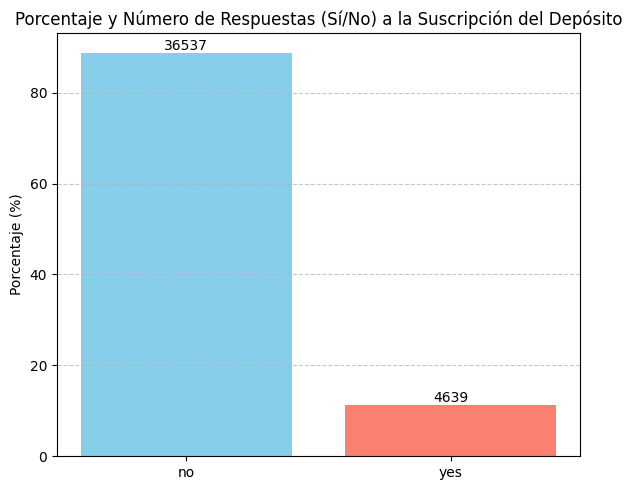

In [ ]:
# Calcular el número absoluto y porcentaje de éxito de la campaña 
y_counts_abs = df_analisis['y'].value_counts()
y_counts_percent = df_analisis['y'].value_counts(normalize=True) * 100

# Crear el gráfico
plt.figure(figsize=(6, 5))
bars = plt.bar(y_counts_abs.index, y_counts_percent, color=['skyblue', 'salmon'])

# Añadir etiquetas con el número de observaciones
for bar, count in zip(bars, y_counts_abs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0, f'{count}', ha='center', va='bottom')

plt.title('Porcentaje y Número de Respuestas (Sí/No) a la Suscripción del Depósito')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 1.6 Conclusiones iniciales 

- **Tamaño inicial**: 41.188 filas × 21 columnas.
- **Nulos**: no hay columnas con nulos.
- **Duplicados exactos**: 12.
- **Unknown en categóricas (top)**: `default` 8.597, `education` 1.731, `housing` 990, `loan` 990, `job` 330, `marital` 80.
- **Objetivo (`y`)**: 4.640 *yes* (11,27%) vs 36.548 *no*.

- **Tratamiento recomendado**:
  - Mantener `duration` sin imputación.
  - Tratar 'unknown' como categoría explícita.
  - Eliminar duplicados exactos (12 filas).
  - Añadir franjas generacionales derivadas de `age`.


# 2. Análisis de variables

En esta sección realizamos un **Análisis Exploratorio de Datos (EDA)** detallado para comprender cómo se comportan las variables del dataset y cuál podría ser su relación con la contratación de un depósito a plazo fijo (`y`).  

Las variables se pueden agrupar en los siguientes bloques:

1. **Variables demográficas del cliente**  
   - `age` -> Edad del cliente.  
   - `job` -> Tipo de trabajo.  
   - `marital` -> Estado civil.  
   - `education` -> Nivel educativo.  

2. **Situación financiera del cliente**  
   - `default` -> Historial de crédito en default.  
   - `housing` -> Préstamo hipotecario.  
   - `loan` -> Préstamo personal.  

3. **Características de la campaña de marketing**  
   - `contact` -> Canal de contacto utilizado (móvil, teléfono fijo).  
   - `month` -> Último mes de contacto.  
   - `day_of_week` -> Día de la semana del último contacto.  
   - `duration` -> Duración de la última llamada (en segundos).  
   - `campaign` -> Número de contactos realizados en la campaña actual.  
   - `pdays` -> Días transcurridos desde la última campaña (999 = no contactado).  
   - `previous` -> Número de contactos en campañas anteriores.  
   - `poutcome` -> Resultado de la campaña anterior.  

4. **Indicadores macroeconómicos**  
   - `emp.var.rate` -> Tasa de variación del empleo (trimestral).  
   - `cons.price.idx` -> Índice de precios al consumidor (mensual).  
   - `cons.conf.idx` -> Índice de confianza del consumidor (mensual).  
   - `euribor3m` -> Tipo de interés Euribor a 3 meses (diario).  
   - `nr.employed` -> Número de empleados (trimestral).  

En esta fase se analizarán las **distribuciones, frecuencias y tasas de conversión** asociadas a cada variable y grupo, con el objetivo de detectar patrones relevantes que nos permitan identificar los segmentos de clientes con mayor probabilidad de suscripción.  

El análisis servirá también para **priorizar variables clave** que se utilizarán más adelante en el **modelo predictivo** y en el **dashboard ejecutivo**.

_____________________________________
De manera visual, profundizaremos en las estadisticas descriptivas y en las hipótesis que se pueden derivar de entender bien cada variable. 

In [ ]:
## Función 1 transformar a tabla 
## Función 2 transformar a gráfico 
## Función 3 mostras varios gráficos juntos 
## Función 4 conclusiones 

In [ ]:
# Descripción + hipótesis de todas las variables del grupo 
# Gráficos
# Resultados observados, validación o desestimación de la hipóteisis
# Interpretación de negocio

## - Funciones de Resumen de Variables

Para analizar cómo se comporta cada variable frente al objetivo `y` (si el cliente contrató un depósito: *yes* / *no*), se ha creado 3 funciones reutilizables, con el objetivo de:  
- Analizar las variables categícas.
- Analizar las variables numéricas.
- Visualizar resultados. 
- Extraer conclusiones. 



In [ ]:
## NIVEL 0 ##

# Función de distribución de catrgorías (Rami) 

def variable_numerica(df, col, bins=10):
    """
    Muestra resumen estadístico y gráfico de una variable numérica.
    """

    print(f"### Análisis de {col}\n")
    print(df[col].describe())

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Histograma
    sns.histplot(df[col], bins=bins, kde=False, ax=ax[0], color="skyblue", edgecolor="black")
    ax[0].set_title(f"Distribución de {col}")

    # Boxplot
    sns.boxplot(x=df[col], ax=ax[1], color="lightgray")
    ax[1].set_title(f"Boxplot de {col}")

    plt.tight_layout()
    plt.show()


def variable_categorica(df, col):
    """
    Muestra frecuencias y gráfico de una variable categórica.
    """

    print(f"### Análisis de {col}\n")
    print(df[col].value_counts(normalize=True).round(3))

    plt.figure(figsize=(8,4))
    sns.countplot(x=df[col], order=df[col].value_counts().index, palette="pastel", edgecolor="black")
    plt.title(f"Distribución de {col}")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
## NIVEL 1 ##

# Función resumen_categórica #

# Columnas que devuelven:  
#   - `total_registros` → número total de clientes en cada categoría.  
#   - `total_yes` → cuántos de esos clientes contrataron (*yes*).  
#   - `porcentaje_yes` → tasa de conversión (%yes).  
#   - `porcentaje_total` → qué % representa esa categoría sobre el total.  

# - Para qué sirven:  
#   - Identificar qué categorías tienen **mayor tasa de conversión**.  
#   - Detectar cuáles son las más representativas en volumen.  
#   - Decidir dónde enfocar campañas: volumen vs eficiencia.
    
def resumen_categorica(df, var, target="y"):

    resumen = df.groupby(var).agg(
        total_registros=(target, "count"),
        total_yes=(target, lambda x: (x == "yes").sum())
    ).reset_index()

    resumen["porcentaje_yes"] = (resumen["total_yes"] / resumen["total_registros"]) * 100
    resumen["porcentaje_total"] = (resumen["total_registros"] / resumen["total_registros"].sum()) * 100

    return resumen.sort_values(by="porcentaje_yes", ascending=False).reset_index(drop=True)


In [ ]:
## Función resumen numérica ## 

# Calcula resumen para una variable numérica binned:
#   - bins de la variable
#   - total de registros
#   - total de 'yes'
#   - porcentaje de 'yes'
#   - porcentaje de representatividad sobre el total

#### Confirmar que es necesaria ####

def resumen_numerica(df, var, target="y", bins=10):
    
    tmp = df.copy()
    tmp["_bin"] = pd.qcut(tmp[var], bins, duplicates="drop")
    
    resumen = tmp.groupby("_bin").agg(
        total_registros=(target, "count"),
        total_yes=(target, lambda x: (x == "yes").sum())
    ).reset_index()

    resumen["porcentaje_yes"] = (resumen["total_yes"] / resumen["total_registros"]) * 100
    resumen["porcentaje_total"] = (resumen["total_registros"] / resumen["total_registros"].sum()) * 100

    return resumen.sort_values(by="_bin").reset_index(drop=True)


In [ ]:
## NIVEL 2 ##

# Función para visualizar los datos de resumen de una única variable en una gráfica. 

# Genera un gráfico combinado para variables categóricas:
#   - Barras = total de 'yes' por categoría
#   - Línea = % de 'yes' (tasa de conversión) por categoría

# Usaremos este paso para no crear tablas resumen y visualizar directamente los datos. 

def plot_resumen_categorica(df, var, target="y"):

# Paso 1: Se repite el paso de crear la tabla resumen, para poder construir el gráfico.
    # Construir el resumen
    resumen = df.groupby(var).agg(
        total_registros=(target, "count"),
        total_yes=(target, lambda x: (x == "yes").sum())
    ).reset_index()
    
    resumen["porcentaje_yes"] = (resumen["total_yes"] / resumen["total_registros"]) * 100
    
    # Ordenar categorías de mayor a menor %yes
    resumen = resumen.sort_values(by="porcentaje_yes", ascending=False).reset_index(drop=True)

# Paso 2: Crear gráfico # 
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Barras: total de yes
    color = "tab:blue"
    ax1.set_xlabel(var)
    ax1.set_ylabel("Total de Yes", color=color)
    bars = ax1.bar(resumen[var], resumen["total_yes"], color=color)
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.set_xticklabels(resumen[var], rotation=45, ha="right")

    # Línea: porcentaje de yes
    ax2 = ax1.twinx()
    color = "tab:red"
    ax2.set_ylabel("% Yes", color=color)
    ax2.plot(resumen[var], resumen["porcentaje_yes"], color=color, marker="o")
    ax2.tick_params(axis="y", labelcolor=color)

    plt.title(f"Total 'Yes' y %Yes por {var}")
    plt.tight_layout()
    plt.show()
    
    return resumen


In [ ]:
# prueba: 
# plot_resumen_categorica(df_analisis, "generation", target="y")

In [ ]:
# Igual que la anterior función, pero agrupa varios gráficos de una única vez,
# para visualizar todas las variables de cada categoría con multiples subplots. 

def plot_resumen_categorica_ax(df, var, ax, target="y", rot=45):
#     Dibuja en 'ax' usando el resumen de tu función resumen_categorica().
#     Barras = total_yes ; Línea = %yes

    data = resumen_categorica(df, var, target=target)  # reutiliza tu función
    x = np.arange(len(data))

    ax2 = ax.twinx()

    # Barras: total_yes
    ax.bar(x, data["total_yes"])
    ax.set_ylabel("Total Yes")
    ax.set_xlabel(var)
    ax.set_xticks(x)
    ax.set_xticklabels(data[var], rotation=rot, ha="right")

    # Línea: %yes
    ax2.plot(x, data["porcentaje_yes"], marker="o",color = "tab:red")
    ax2.set_ylabel("% Yes")

    ax.set_title(f"{var}: Total Yes y %Yes")
    for i, v in enumerate(data["total_yes"]):
        ax.text(i, v, f"{int(v)}", ha="center", va="bottom", fontsize=8)


def plot_resumen_numerica(df, var, ax, target="y", bins=6, rot=45):
    
    # Dibuja en 'ax' usando el resumen de tu función resumen_numerica().
    # Barras = total_yes por bin ; Línea = %yes por bin
    
    data = resumen_numerica(df, var, target=target, bins=bins)  # reutiliza tu función
    # En tu implementación, la columna de bins se llama "_bin"
    bin_col = "_bin" if "_bin" in data.columns else var
    xlabels = data[bin_col].astype(str).tolist()
    x = np.arange(len(data))

    ax2 = ax.twinx()

    # Barras: total_yes por bin
    ax.bar(x, data["total_yes"])
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=rot, ha="right")
    ax.set_ylabel("Total Yes")
    ax.set_xlabel(var)

    # Línea: %yes por bin
    ax2.plot(x, data["porcentaje_yes"], marker="o")
    ax2.set_ylabel("% Yes")

    ax.set_title(f"{var} (bins): Total Yes y %Yes")
    for i, v in enumerate(data["total_yes"]):
        ax.text(i, v, f"{int(v)}", ha="center", va="bottom", fontsize=8)


In [ ]:
## NIVEL 3 ##

# Función de conclusiones.  

    # Genera texto Markdown con:
    # Resultados observados
    # - Distribución (top por %total)
    # - Tasa de conversión (top por %yes)

    # Interpretación de negocio
    # - Segmentos de alto impacto (volumen alto + %yes > baseline)
    # - Segmentos a optimizar (volumen alto + %yes < baseline)
    # - Nichos rentables (volumen bajo + %yes alto)


def conclusiones_categorica(df, var, target="y", min_pct_total=5.0, top_k=3, mostrar=True):
    
    base = 100.0 * (df[target].astype(str).str.lower() == "yes").mean()
    tab = resumen_categorica(df, var, target)  # usa tu función

    # Mapear nombres por si varía el casing
    cols = {c.lower(): c for c in tab.columns}
    pct_yes = cols.get("porcentaje_yes", "porcentaje_yes")
    pct_total = cols.get("porcentaje_total", "porcentaje_total")

    # TOP volumen y TOP conversión
    top_vol = tab.sort_values(pct_total, ascending=False).head(top_k)
    top_conv = tab.sort_values(pct_yes, ascending=False).head(top_k)

    # Alto impacto (volumen relevante + conversión > baseline)
    alto_impacto = tab[(tab[pct_total] >= min_pct_total) & (tab[pct_yes] > base)] \
        .sort_values([pct_yes, pct_total], ascending=[False, False])

    # A optimizar (volumen relevante + conversión < baseline)
    optimizar = tab[(tab[pct_total] >= min_pct_total) & (tab[pct_yes] < base)] \
        .sort_values([pct_total, pct_yes], ascending=[False, True])

    # Nichos (volumen bajo + alta conversión)
    nichos = tab[tab[pct_total] < min_pct_total].sort_values(pct_yes, ascending=False).head(top_k)

    from IPython.display import Markdown, display

    def _fmt_pct(x, dec=1):
        try:
            return f"{float(x):.{dec}f}%"
        except Exception:
            return "-"

    md = [f"### Variable: **{var}**",
          "#### 📊 Resultados observados",
          f"- **Baseline conversión**: " + _fmt_pct(base),
          f"- **Top volumen**: " + ", ".join([f"`{r[var]}` ({_fmt_pct(r[pct_total])})" for _, r in top_vol.iterrows()]) if len(top_vol) else "-",
          f"- **Top conversión**: " + ", ".join([f"`{r[var]}` ({_fmt_pct(r[pct_yes])})" for _, r in top_conv.iterrows()]) if len(top_conv) else "-",
          "",
          "#### 📈 Interpretación de negocio"]

    if len(alto_impacto):
        md.append("- **Segmentos de alto impacto** (volumen alto y conversión > baseline): " +
                  ", ".join([f"`{r[var]}` ({_fmt_pct(r[pct_total])} del total, {_fmt_pct(r[pct_yes])} conv.)"
                             for _, r in alto_impacto.iterrows()]))
    else:
        md.append("- **Segmentos de alto impacto**: no se identifican con el umbral actual.")

    if len(optimizar):
        md.append("- **Segmentos a optimizar** (volumen alto pero conversión < baseline): " +
                  ", ".join([f"`{r[var]}` ({_fmt_pct(r[pct_total])} del total, {_fmt_pct(r[pct_yes])} conv.)"
                             for _, r in optimizar.head(top_k).iterrows()]))
    else:
        md.append("- **Segmentos a optimizar**: no se identifican con el umbral actual.")

    if len(nichos):
        md.append("- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): " +
                  ", ".join([f"`{r[var]}` ({_fmt_pct(r[pct_total])} del total, {_fmt_pct(r[pct_yes])} conv.)"
                             for _, r in nichos.iterrows()]))
    else:
        md.append("- **Nichos potencialmente rentables**: no destacables con el umbral actual.")

    text = "\n".join(md)
    if mostrar:
        display(Markdown(text))
    return


## 2.1 Variables demográficas del cliente

- `age` -> Edad del cliente.  
- `job` -> Tipo de trabajo.  
- `marital` -> Estado civil.  
- `education` -> Nivel educativo.  

---

## Hipótesis de cada variable

**Edad**: Representa la edad del cliente en años. Es un factor clave que refleja la etapa de la vida y la capacidad de ahorro/inversión.
- Hipótesis: 
  - Jóvenes (<25) -> menor propensión a contratar depósitos (menores ingresos, más gasto en consumo).  
  - Adultos (25–55) -> mayor capacidad de ahorro, target principal de las campañas.  
  - Mayores (>65) -> pueden valorar seguridad de depósitos como complemento de pensión.  


**Tipo de Trabajo**: Identifica el sector o tipo de empleo del cliente. Refleja estabilidad laboral, ingresos y estilo de vida.
- Hipótesis: 
  - Profesionales cualificados (admin., technician) -> mayor estabilidad, más propensos a contratar depósitos.  
  - Trabajadores manuales (blue-collar) -> menor propensión por ingresos menos estables.  
  - Estudiantes y desempleados -> baja capacidad de ahorro.  
  - Jubilados (retired) -> potencial interés en productos seguros de renta fija.  


**Estado Civil**:
Refleja el estado civil del cliente, que influye en sus responsabilidades económicas y prioridades de ahorro.
- Hipótesis:
  - Casados -> mayor propensión (responsabilidades familiares, buscan estabilidad).  
  - Solteros -> autonomía en ingresos, pueden priorizar consumo o riesgo.  
  - Divorciados/viudos -> necesidades específicas (pensión, estabilidad).  


**Nivel Educativo**: Mide el nivel de estudios alcanzado por el cliente. Suele estar correlacionado con nivel de ingresos y cultura financiera.
- Hipótesis:
  - Universitarios -> mayor propensión a contratar depósitos (mejor cultura financiera, ingresos más altos).  
  - Educación secundaria -> intermedia.  
  - Educación básica o desconocida -> menor interés o capacidad de ahorro. 

### Análisis de age

count    41176.00000
mean        40.02380
std         10.42068
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64


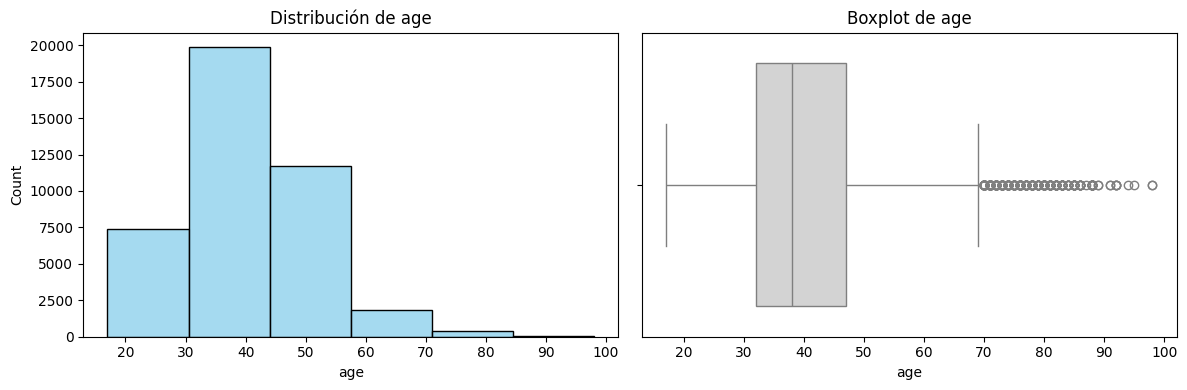

### Análisis de job

job
admin.           0.253
blue-collar      0.225
technician       0.164
services         0.096
management       0.071
retired          0.042
entrepreneur     0.035
self-employed    0.035
housemaid        0.026
unemployed       0.025
student          0.021
unknown          0.008
Name: proportion, dtype: float64


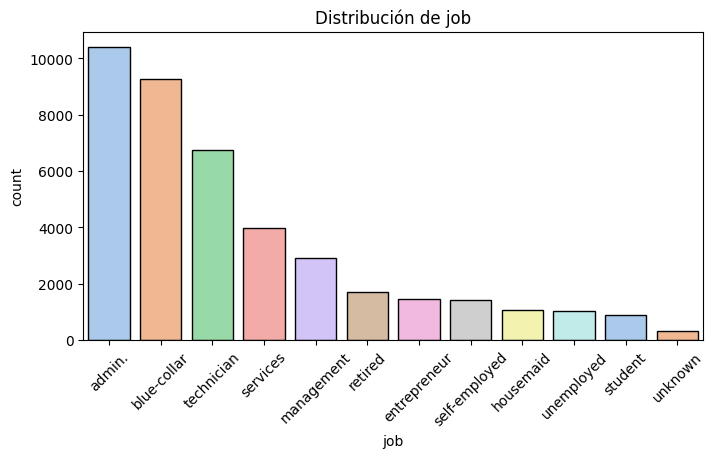

### Análisis de education

education
university.degree      0.295
high.school            0.231
basic.9y               0.147
professional.course    0.127
basic.4y               0.101
basic.6y               0.056
unknown                0.042
illiterate             0.000
Name: proportion, dtype: float64


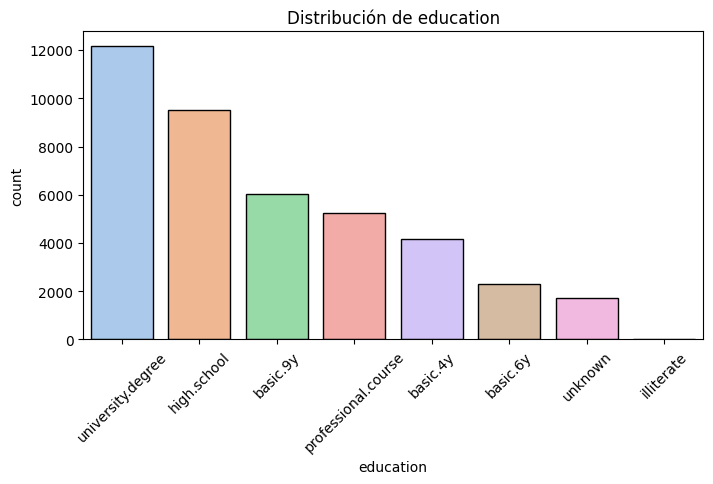

### Análisis de marital

marital
married     0.605
single      0.281
divorced    0.112
unknown     0.002
Name: proportion, dtype: float64


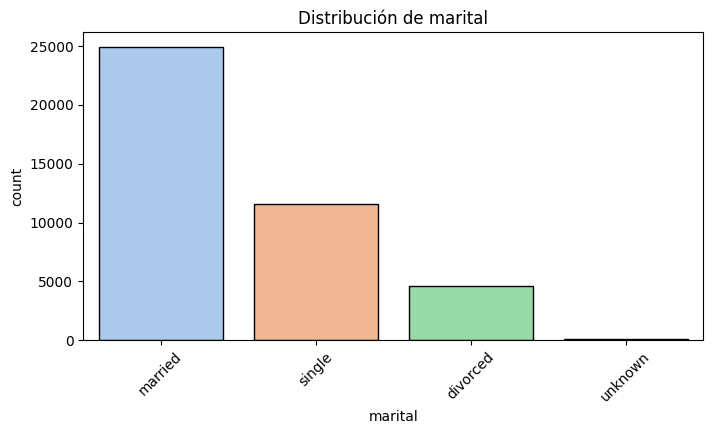

In [ ]:
# Distribución de categorías: 

# Edad (numérica)
_ = variable_numerica(df_analisis, "age", bins=6)

# Job (categórica)
_ = variable_categorica(df_analisis, "job")

# Education (categórica)
_ = variable_categorica(df_analisis, "education")

# Marital (categórica)
_ = variable_categorica(df_analisis, "marital")

In [ ]:
# ==============================
# Análisis Variables Demográficas
# ==============================

# Edad (agurpada por generación)
print("### Edad (age)")
display(resumen_categorica(df_analisis, "generation")) 

# Tipo de trabajo (categórica)
print("### Tipo de Trabajo (job)")
display(resumen_categorica(df_analisis, "job"))

# Estado civil (categórica)
print("### Estado Civil (marital)")
display(resumen_categorica(df_analisis, "marital"))

# Nivel educativo (categórica)
print("### Nivel Educativo (education)")
display(resumen_categorica(df_analisis, "education"))


### Edad (age)


,generation,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,Other,2,2,100.000000,0.004857
1,Silent Generation (<97),148,75,50.675676,0.359433
2,Baby Boomers (<79),759,337,44.400527,1.843307
3,Gen Z (<28),4214,736,17.465591,10.234117
4,Millennials (<44),24032,2354,9.795273,58.364096
5,Gen X (<60),12021,1135,9.441810,29.194191


### Tipo de Trabajo (job)


,job,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,student,875,275,31.428571,2.125024
1,retired,1718,434,25.261932,4.172333
2,unemployed,1014,144,14.201183,2.462600
3,admin.,10419,1351,12.966695,25.303575
4,management,2924,328,11.217510,7.101224
5,unknown,330,37,11.212121,0.801438
6,technician,6739,730,10.832468,16.366330
7,self-employed,1421,149,10.485574,3.451039
8,housemaid,1060,106,10.000000,2.574315
9,entrepreneur,1456,124,8.516484,3.536040


### Estado Civil (marital)


,marital,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,unknown,80,12,15.000000,0.194288
1,single,11564,1620,14.008993,28.084321
2,divorced,4611,476,10.323140,11.198271
3,married,24921,2531,10.156093,60.523120


### Nivel Educativo (education)


,education,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,illiterate,18,4,22.222222,0.043715
1,unknown,1730,251,14.508671,4.201477
2,university.degree,12164,1669,13.720816,29.541480
3,professional.course,5240,595,11.354962,12.725860
4,high.school,9512,1031,10.838940,23.100835
5,basic.4y,4176,428,10.249042,10.141830
6,basic.6y,2291,188,8.206024,5.563921
7,basic.9y,6045,473,7.824648,14.680882


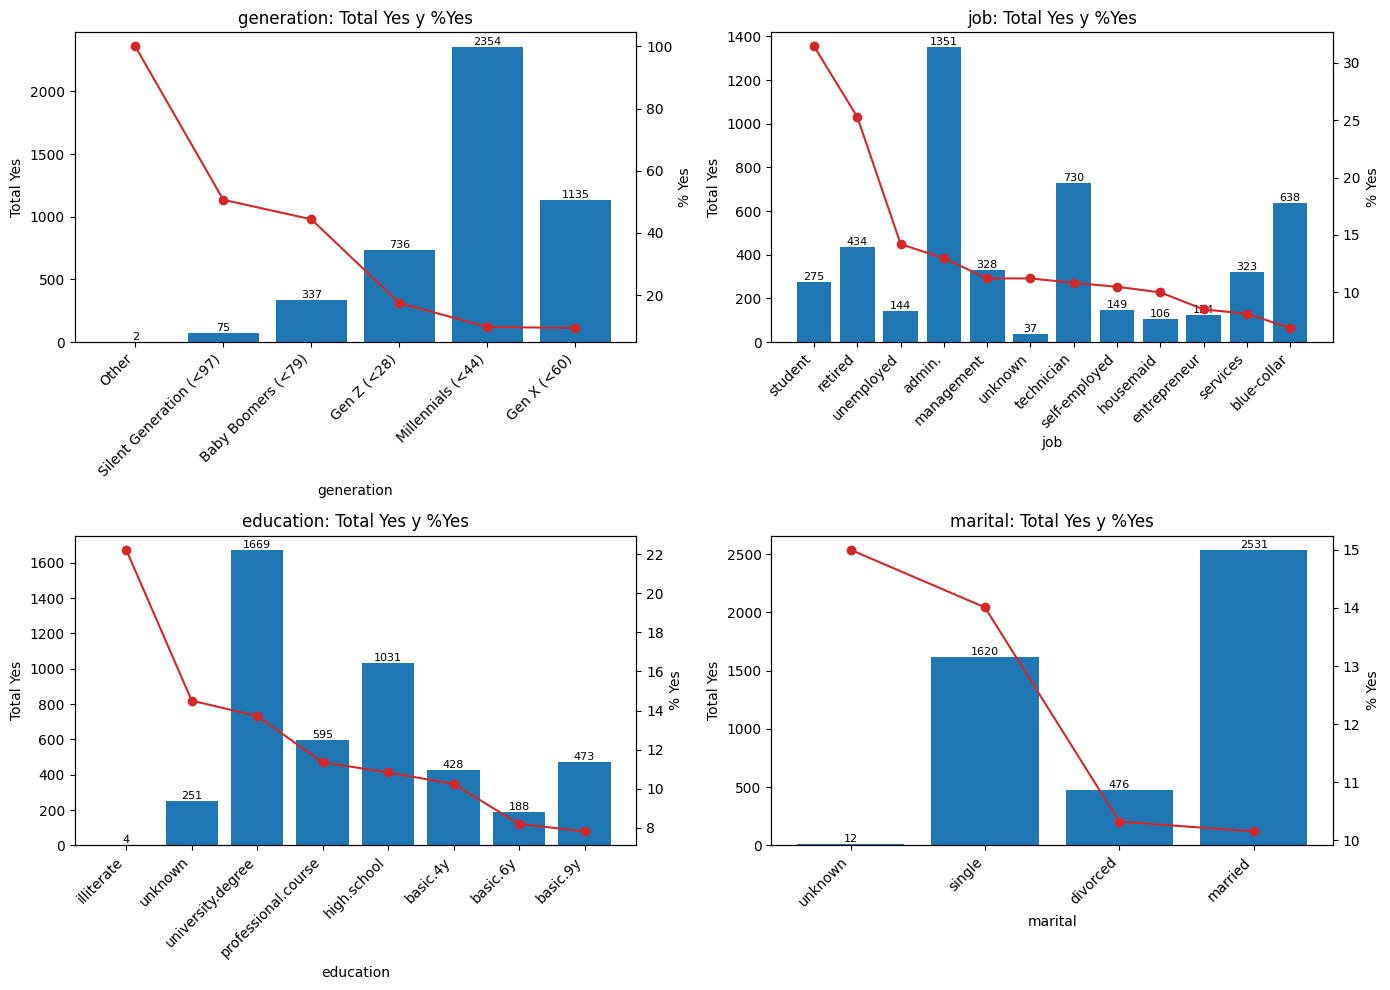

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Edad (numérica)
plot_resumen_categorica_ax(df_analisis, "generation", axes[0, 0])

# 2) Job (categórica)
plot_resumen_categorica_ax(df_analisis, "job", axes[0, 1])

# 3) Education (categórica)
plot_resumen_categorica_ax(df_analisis, "education", axes[1, 0])

# 4) Marital (categórica)
plot_resumen_categorica_ax(df_analisis, "marital", axes[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
# Edad (numérica)
_ = conclusiones_categorica(df_analisis, "generation")

# Job (categórica)
_ = conclusiones_categorica(df_analisis, "job")

# Education (categórica)
_ = conclusiones_categorica(df_analisis, "education")

# Marital (categórica)
_ = conclusiones_categorica(df_analisis, "marital")

### Variable: **generation**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `Millennials (<44)` (58.4%), `Gen X (<60)` (29.2%), `Gen Z (<28)` (10.2%)
- **Top conversión**: `Other` (100.0%), `Silent Generation (<97)` (50.7%), `Baby Boomers (<79)` (44.4%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `Gen Z (<28)` (10.2% del total, 17.5% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `Millennials (<44)` (58.4% del total, 9.8% conv.), `Gen X (<60)` (29.2% del total, 9.4% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `Other` (0.0% del total, 100.0% conv.), `Silent Generation (<97)` (0.4% del total, 50.7% conv.), `Baby Boomers (<79)` (1.8% del total, 44.4% conv.)

### Variable: **job**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `admin.` (25.3%), `blue-collar` (22.5%), `technician` (16.4%)
- **Top conversión**: `student` (31.4%), `retired` (25.3%), `unemployed` (14.2%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `admin.` (25.3% del total, 13.0% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `blue-collar` (22.5% del total, 6.9% conv.), `technician` (16.4% del total, 10.8% conv.), `services` (9.6% del total, 8.1% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `student` (2.1% del total, 31.4% conv.), `retired` (4.2% del total, 25.3% conv.), `unemployed` (2.5% del total, 14.2% conv.)

### Variable: **education**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `university.degree` (29.5%), `high.school` (23.1%), `basic.9y` (14.7%)
- **Top conversión**: `illiterate` (22.2%), `unknown` (14.5%), `university.degree` (13.7%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `university.degree` (29.5% del total, 13.7% conv.), `professional.course` (12.7% del total, 11.4% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `high.school` (23.1% del total, 10.8% conv.), `basic.9y` (14.7% del total, 7.8% conv.), `basic.4y` (10.1% del total, 10.2% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `illiterate` (0.0% del total, 22.2% conv.), `unknown` (4.2% del total, 14.5% conv.)

### Variable: **marital**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `married` (60.5%), `single` (28.1%), `divorced` (11.2%)
- **Top conversión**: `unknown` (15.0%), `single` (14.0%), `divorced` (10.3%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `single` (28.1% del total, 14.0% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `married` (60.5% del total, 10.2% conv.), `divorced` (11.2% del total, 10.3% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `unknown` (0.2% del total, 15.0% conv.)

---
---

Validación de hipótesis: 

## 1
## 2
## 3

## 2.2 Situación financiera del cliente

- `default` -> Cliente con créditos impagados.  
- `housing` -> Si el cliente tiene hipoteca.  
- `loan` -> Si el cliente tiene préstamo personal.  

---

## Hipótesis de cada variable

**Créditos impagados (default)**: Indica si el cliente tiene deudas vencidas.  
- Hipótesis:  
  - `yes` -> menor probabilidad de contratar, dado que refleja riesgo financiero y menor capacidad de ahorro.  
  - `no` -> mayor disposición a invertir.   

**Hipoteca (housing)**: Informa si el cliente está pagando una vivienda.  
- Hipótesis:  
  - Con hipoteca -> menor margen de ahorro, menos propensos a contratar depósitos.  
  - Sin hipoteca -> mayor liquidez, más probabilidad de invertir.   

**Préstamo personal (loan)**: Indica si el cliente tiene préstamos al consumo.  
- Hipótesis:  
  - Con préstamo -> menor capacidad de ahorro, menos propensos a contratar.  
  - Sin préstamo -> mayor capacidad de ahorro e inversión.  

---

 *A continuación se presenta el gráfico comparativo de las tres variables financieras.*  

### Análisis de default

default
no         0.791
unknown    0.209
yes        0.000
Name: proportion, dtype: float64


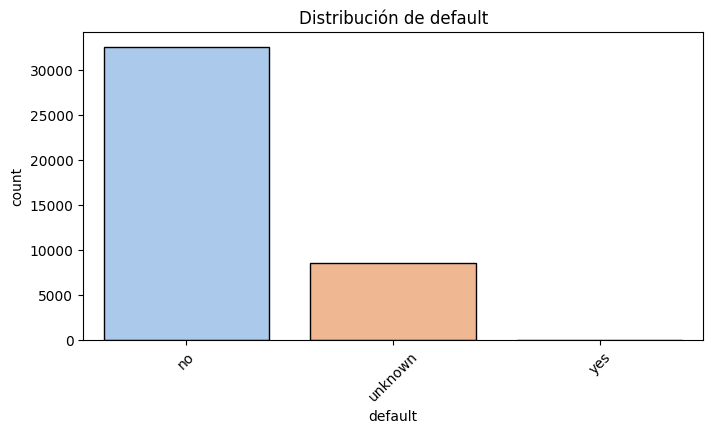

### Análisis de housing

housing
yes        0.524
no         0.452
unknown    0.024
Name: proportion, dtype: float64


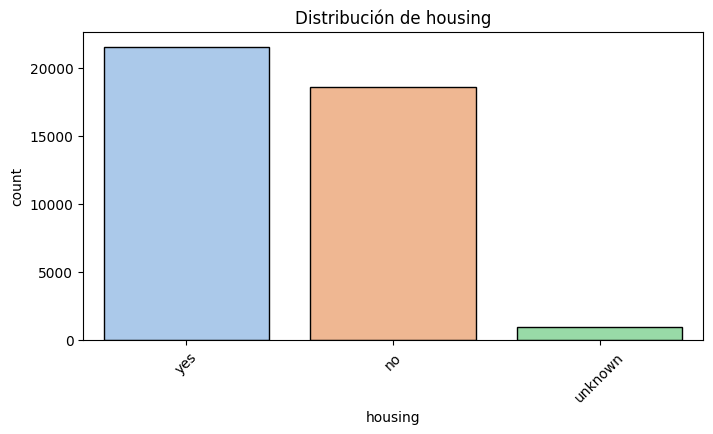

### Análisis de loan

loan
no         0.824
yes        0.152
unknown    0.024
Name: proportion, dtype: float64


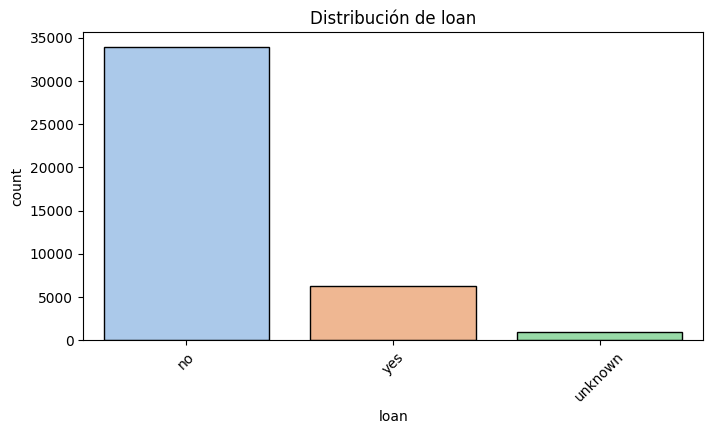

In [ ]:
# Distribución de categorías: 

# Edad (numérica)
_ = variable_categorica(df_analisis, "default")

# Job (categórica)
_ = variable_categorica(df_analisis, "housing")

# Education (categórica)
_ = variable_categorica(df_analisis, "loan")

In [ ]:
# ==============================
# Análisis Variables Financieras
# ==============================

# Créditos impagados (default)
print("### Créditos impagados (default)")
display(resumen_categorica(df_analisis, "default")) 

# Hipoteca (housing)
print("### Hipoteca (housing)")
display(resumen_categorica(df_analisis, "housing"))

# Préstamo personal (loan)
print("### Préstamo personal (loan)")
display(resumen_categorica(df_analisis, "loan"))

### Créditos impagados (default)


,default,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,no,32577,4196,12.880253,79.116476
1,unknown,8596,443,5.153560,20.876239
2,yes,3,0,0.000000,0.007286


### Hipoteca (housing)


,housing,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,yes,21571,2507,11.622085,52.387313
1,no,18615,2025,10.878324,45.208374
2,unknown,990,107,10.808081,2.404313


### Préstamo personal (loan)


,loan,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,no,33938,3849,11.341269,82.421799
1,yes,6248,683,10.931498,15.173888
2,unknown,990,107,10.808081,2.404313


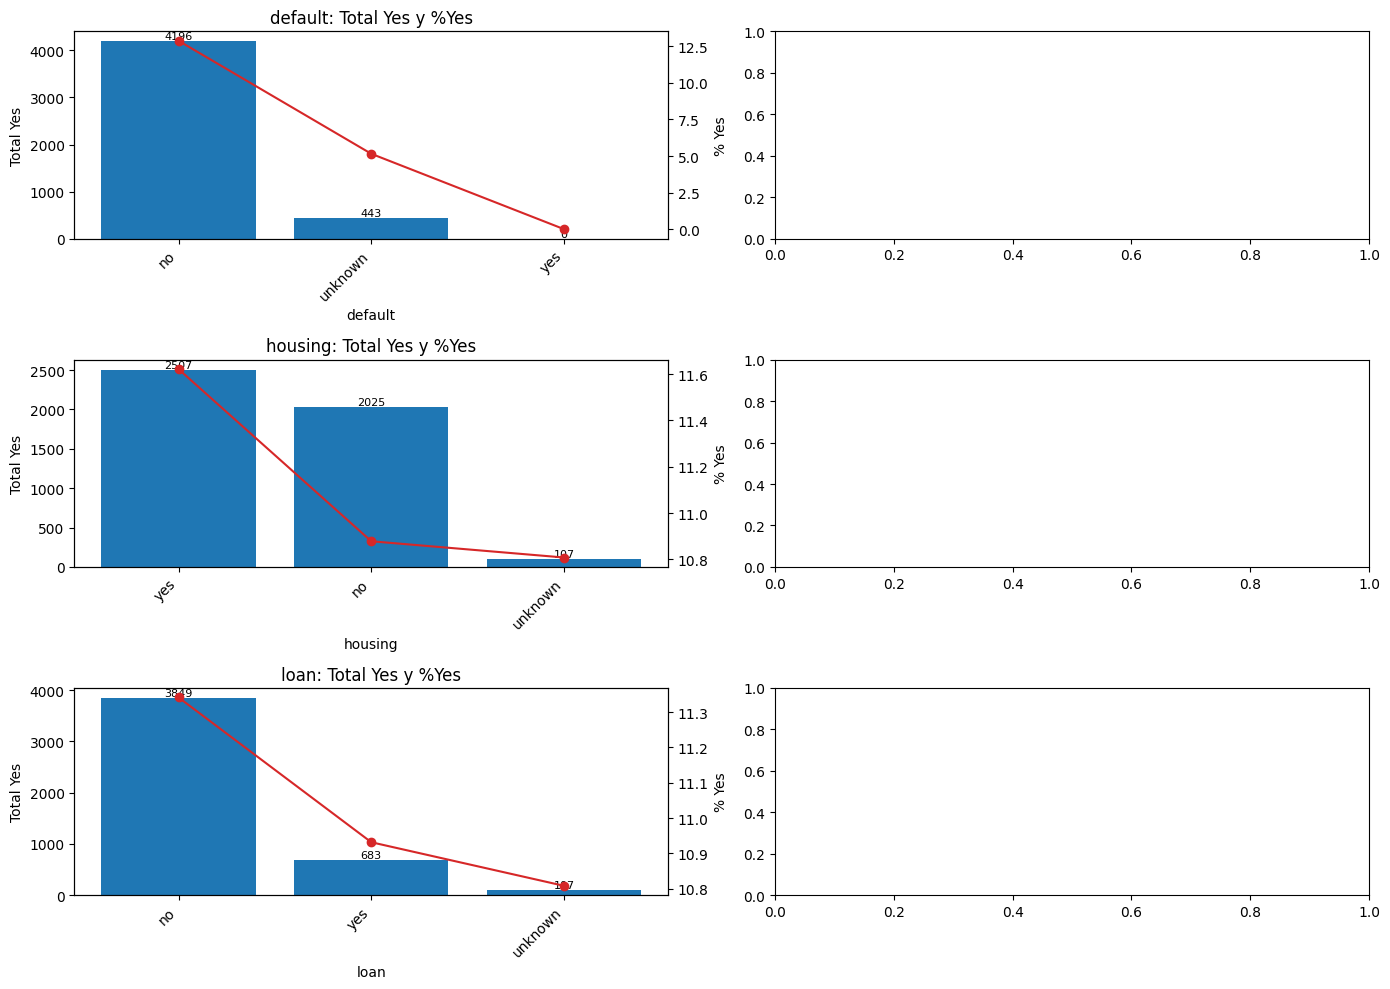

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# 1) Créditos impagados (default)
plot_resumen_categorica_ax(df_analisis, "default", axes[0, 0])

# 2) Hipoteca (housing)
plot_resumen_categorica_ax(df_analisis, "housing", axes[1, 0])

# 3) Préstamo personal (loan)
plot_resumen_categorica_ax(df_analisis, "loan", axes[2, 0])


plt.tight_layout()
plt.show()

In [ ]:
# 1) Créditos impagados (default)
_ = conclusiones_categorica(df_analisis, "default")

# 2) Hipoteca (housing)
_ = conclusiones_categorica(df_analisis, "housing")

# 3) Préstamo personal (loan)
_ = conclusiones_categorica(df_analisis, "loan")

### Variable: **default**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `no` (79.1%), `unknown` (20.9%), `yes` (0.0%)
- **Top conversión**: `no` (12.9%), `unknown` (5.2%), `yes` (0.0%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `no` (79.1% del total, 12.9% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `unknown` (20.9% del total, 5.2% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `yes` (0.0% del total, 0.0% conv.)

### Variable: **housing**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `yes` (52.4%), `no` (45.2%), `unknown` (2.4%)
- **Top conversión**: `yes` (11.6%), `no` (10.9%), `unknown` (10.8%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `yes` (52.4% del total, 11.6% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `no` (45.2% del total, 10.9% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `unknown` (2.4% del total, 10.8% conv.)

### Variable: **loan**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `no` (82.4%), `yes` (15.2%), `unknown` (2.4%)
- **Top conversión**: `no` (11.3%), `yes` (10.9%), `unknown` (10.8%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `no` (82.4% del total, 11.3% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `yes` (15.2% del total, 10.9% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `unknown` (2.4% del total, 10.8% conv.)

- Hipótesisi y conclusiones personales 

# 1
# 2

In [ ]:
# # Distribución de variables financieras (2.2)
# import pandas as pd
# import matplotlib.pyplot as plt

# # Si tu DataFrame se llama distinto, ajusta aquí:
# df_analisis = df_analisis.copy()

# fin_vars = ["default", "housing", "loan"]
# cat_order = {
#     "default": ["no", "unknown", "yes"],
#     "housing": ["no", "unknown", "yes"],
#     "loan":    ["no", "unknown", "yes"],
# }

# # Figura 1x3 (respeta tu estilo/rcParams existentes)
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# for i, var in enumerate(fin_vars):
#     ax = axes[i]

#     # Proporciones
#     vc = (
#         df_analisis[var]
#         .astype("category")
#         .cat.set_categories(cat_order[var], ordered=True)
#         .value_counts(normalize=True)
#         .sort_index()
#         .rename("Proporción")
#     )

#     # Barras (sin fijar colores para respetar tu tema actual)
#     vc.plot(kind="bar", ax=ax, rot=0)

#     # Títulos y ejes
#     ax.set_title(f"Distribución de {var}", pad=10)
#     ax.set_ylabel("Proporción")
#     ax.set_xlabel("")

#     # Grid suave si tu tema lo permite
#     ax.grid(axis="y", linestyle="--", alpha=0.3)

#     # Anotar porcentajes encima de cada barra
#     for p in ax.patches:
#         height = p.get_height()
#         if pd.notna(height):
#             ax.annotate(f"{height*100:.1f}%",
#                         (p.get_x() + p.get_width()/2, height),
#                         ha="center", va="bottom", fontsize=9, xytext=(0, 3),
#                         textcoords="offset points")

# plt.tight_layout()
# plt.show()

In [ ]:
# # --- Distribución de variables financieras (2.2) con relación a la edad ---
# import matplotlib.pyplot as plt
# import seaborn as sns

# fin_vars = ["default", "housing", "loan"]
# cat_order = {
#     "default": ["no", "unknown", "yes"],
#     "housing": ["no", "unknown", "yes"],
#     "loan":    ["no", "unknown", "yes"],
# }

# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# for i, var in enumerate(fin_vars):
#     ax = axes[i]

#     # Boxplot de edad según la categoría financiera
#     sns.boxplot(
#         data=df_analisis,
#         x=var,
#         y="age",
#         order=cat_order[var],
#         ax=ax
#     )

#     ax.set_title(f"Edad según {var}", pad=10)
#     ax.set_xlabel(var.capitalize())
#     ax.set_ylabel("Edad" if i == 0 else "")

# plt.tight_layout()
# plt.show()

## 2.3 Características de la campaña de marketing

- `contact` -> Medio de contacto con el cliente.  
- `month` -> Mes del contacto.  
- `day_of_week` -> Día de la semana del contacto.  
- `duration` -> Duración de la llamada (segundos).  
- `campaign` -> Nº de contactos realizados en la campaña actual.  
- `pdays` -> Días desde el último contacto previo (999 = nunca).  
- `previous` -> Nº de contactos previos.  
- `poutcome` -> Resultado de la campaña anterior.  

---

## Hipótesis de cada variable

**Tipo de contacto (contact)**: Canal utilizado para llegar al cliente.  
- Hipótesis:  
  - Es indiferente si se contacta por celular o por teléfono.  

**Mes del contacto (month)**: Momento temporal en el que se realiza la campaña.  
- Hipótesis:  
  - Estacionalidad influye en la disposición a solicitar el prestamo. Los meses de mayo - julio, la gente tendrá solicitará más presatamos de cara al verano.  

**Día de la semana (day_of_week)**: Momento de la semana que puede influir en la receptividad.  
- Hipótesis:  
  - Lunes-viernes sin diferencias notables, aunque días cercanos a fin de semana podrían ser menos efectivos.  

**Duración de la llamada (duration)**: Longitud del contacto telefónico.  
- Hipótesis:  
  - A mayor duración mayor interés y probabilidad de conversión.   

**Nº de contactos en la campaña (campaign)**: Cantidad de intentos en la campaña actual.  
- Hipótesis:  
  - Pocos intentos -> mayor efectividad.  
  - Muchos intentos -> fatiga del cliente, baja conversión.  

**Días desde el último contacto (pdays)**: Tiempo transcurrido desde la última interacción.  
- Hipótesis:  
  - Contactos recientes (pdays < 999) -> mayor probabilidad de éxito.  
  - Valor 999 (nunca contactados) -> grupo predominante, menor predisposición.  

**Nº de contactos anteriores (previous)**: Histórico de contactos previos.  
- Hipótesis:  
  - Clientes con interacciones previas -> más propensos a convertir.  
  - Clientes nunca contactados -> menor tasa de conversión.  

**Resultado de campaña anterior (poutcome)**: Efectividad de la última campaña.  
- Hipótesis:  
  - `success` -> mucho mayor probabilidad de éxito actual.  
  - `failure` o `nonexistent` -> menor predisposición.  

 *A continuación se presentan los gráficos de cada una de estas variables para visualizar su distribución y relación con la respuesta.*  

### Análisis de contact

contact
cellular     0.635
telephone    0.365
Name: proportion, dtype: float64


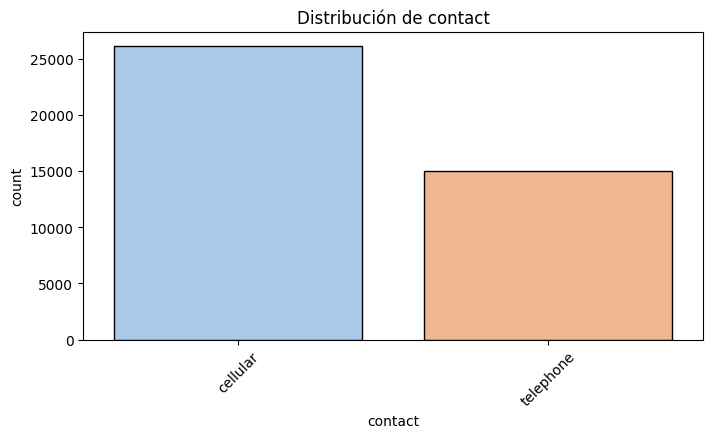

### Análisis de month

month
may    0.334
jul    0.174
aug    0.150
jun    0.129
nov    0.100
apr    0.064
oct    0.017
sep    0.014
mar    0.013
dec    0.004
Name: proportion, dtype: float64


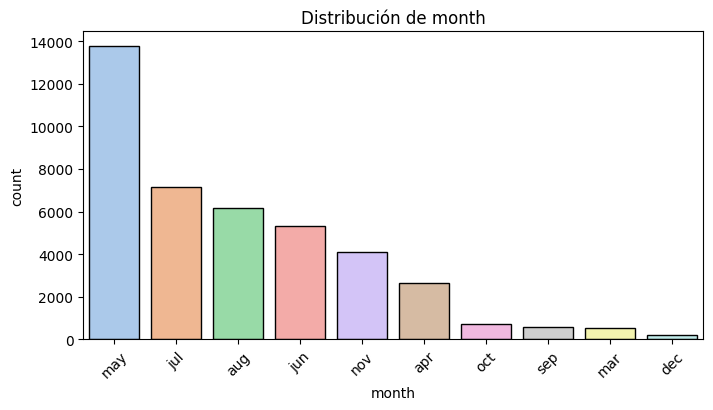

### Análisis de day_of_week

day_of_week
thu    0.209
mon    0.207
wed    0.198
tue    0.196
fri    0.190
Name: proportion, dtype: float64


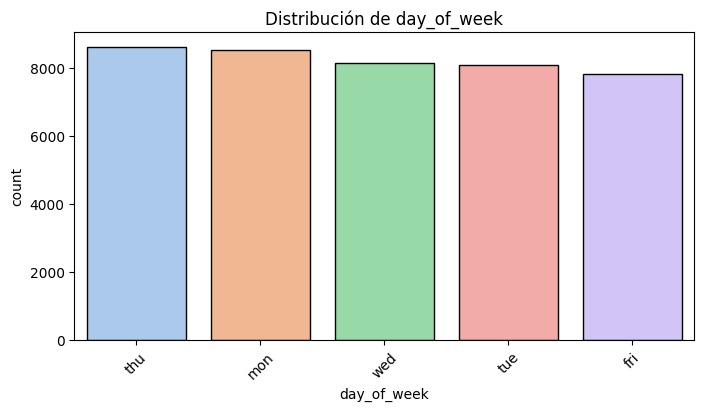

### Análisis de duration

count    41176.000000
mean       258.315815
std        259.305321
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64


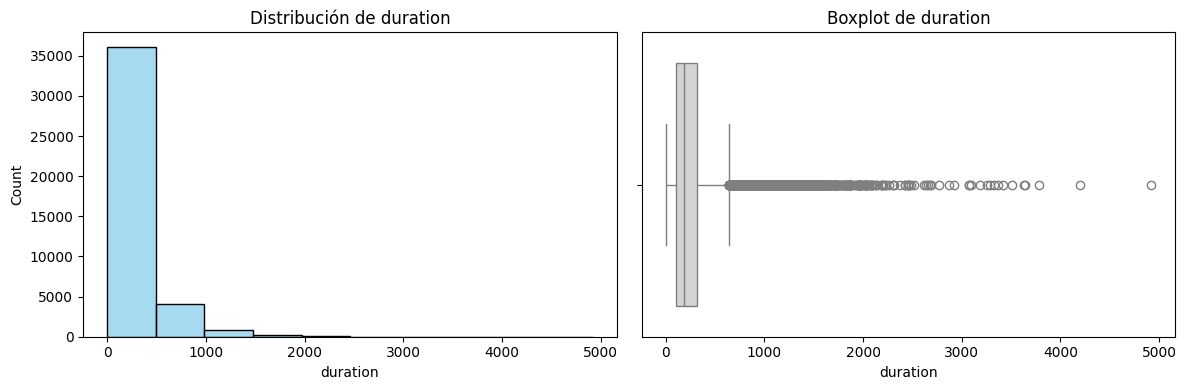

### Análisis de campaign

campaign
1     0.428
2     0.257
3     0.130
4     0.064
5     0.039
6     0.024
7     0.015
8     0.010
9     0.007
10    0.005
11    0.004
12    0.003
13    0.002
14    0.002
17    0.001
16    0.001
15    0.001
18    0.001
20    0.001
19    0.001
21    0.001
22    0.000
23    0.000
24    0.000
27    0.000
29    0.000
28    0.000
26    0.000
25    0.000
31    0.000
30    0.000
35    0.000
32    0.000
33    0.000
34    0.000
42    0.000
40    0.000
43    0.000
56    0.000
39    0.000
41    0.000
37    0.000
Name: proportion, dtype: float64


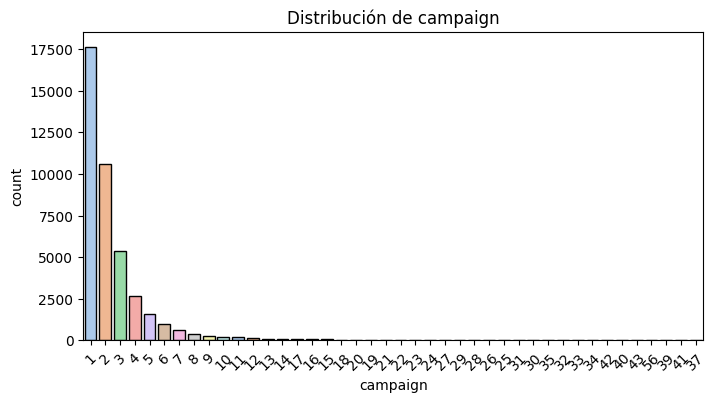

### Análisis de pdays

pdays
999    0.963
3      0.011
6      0.010
4      0.003
9      0.002
2      0.001
7      0.001
12     0.001
10     0.001
5      0.001
13     0.001
11     0.001
1      0.001
15     0.001
14     0.000
8      0.000
0      0.000
16     0.000
17     0.000
18     0.000
22     0.000
19     0.000
21     0.000
25     0.000
26     0.000
27     0.000
20     0.000
Name: proportion, dtype: float64


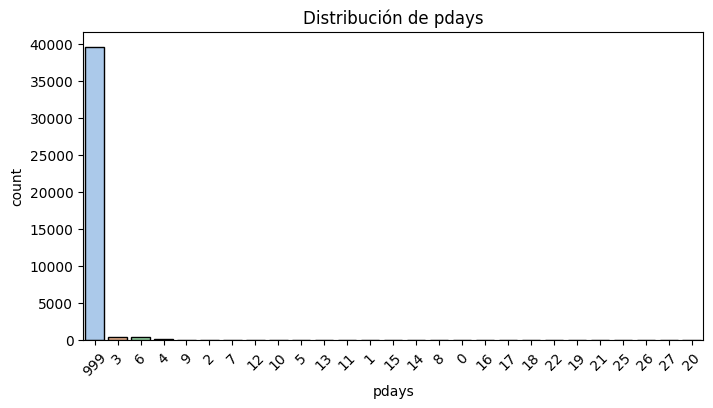

### Análisis de previous

previous
0    0.863
1    0.111
2    0.018
3    0.005
4    0.002
5    0.000
6    0.000
7    0.000
Name: proportion, dtype: float64


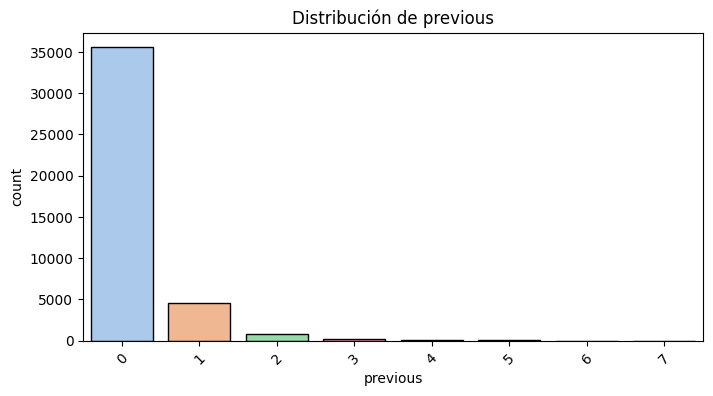

### Análisis de poutcome

poutcome
nonexistent    0.863
failure        0.103
success        0.033
Name: proportion, dtype: float64


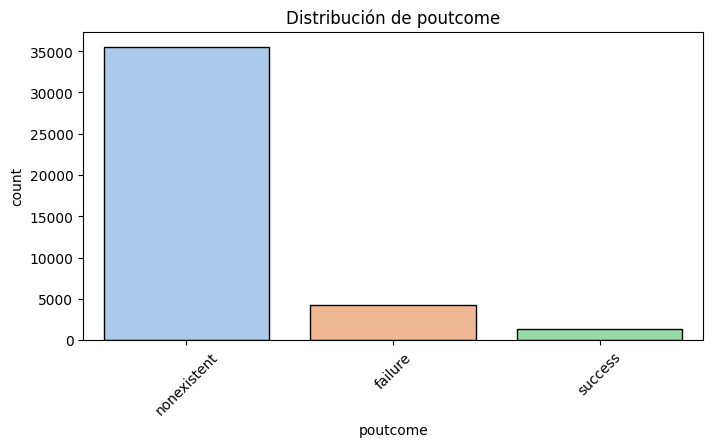

In [ ]:
# Distribución de categorías: 

_ = variable_categorica(df_analisis, "contact")

_ = variable_categorica(df_analisis, "month")

_ = variable_categorica(df_analisis, "day_of_week")

_ = variable_numerica(df_analisis, "duration", bins=10)

_ = variable_categorica(df_analisis, "campaign")

_ = variable_categorica(df_analisis, "pdays")

_ = variable_categorica(df_analisis, "previous")

_ = variable_categorica(df_analisis, "poutcome")

In [ ]:
# ==============================
# Análisis Variables de Campaña
# ==============================

# Edad (agurpada por generación)
print("### Edad (age)")
display(resumen_categorica(df_analisis, "generation")) 

# Tipo de trabajo (categórica)
print("### Tipo de Trabajo (job)")
display(resumen_categorica(df_analisis, "job"))

# Estado civil (categórica)
print("### Estado Civil (marital)")
display(resumen_categorica(df_analisis, "marital"))

# Nivel educativo (categórica)
print("### Nivel Educativo (education)")
display(resumen_categorica(df_analisis, "education"))

### Edad (age)


,generation,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,Other,2,2,100.000000,0.004857
1,Silent Generation (<97),148,75,50.675676,0.359433
2,Baby Boomers (<79),759,337,44.400527,1.843307
3,Gen Z (<28),4214,736,17.465591,10.234117
4,Millennials (<44),24032,2354,9.795273,58.364096
5,Gen X (<60),12021,1135,9.441810,29.194191


### Tipo de Trabajo (job)


,job,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,student,875,275,31.428571,2.125024
1,retired,1718,434,25.261932,4.172333
2,unemployed,1014,144,14.201183,2.462600
3,admin.,10419,1351,12.966695,25.303575
4,management,2924,328,11.217510,7.101224
5,unknown,330,37,11.212121,0.801438
6,technician,6739,730,10.832468,16.366330
7,self-employed,1421,149,10.485574,3.451039
8,housemaid,1060,106,10.000000,2.574315
9,entrepreneur,1456,124,8.516484,3.536040


### Estado Civil (marital)


,marital,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,unknown,80,12,15.000000,0.194288
1,single,11564,1620,14.008993,28.084321
2,divorced,4611,476,10.323140,11.198271
3,married,24921,2531,10.156093,60.523120


### Nivel Educativo (education)


,education,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,illiterate,18,4,22.222222,0.043715
1,unknown,1730,251,14.508671,4.201477
2,university.degree,12164,1669,13.720816,29.541480
3,professional.course,5240,595,11.354962,12.725860
4,high.school,9512,1031,10.838940,23.100835
5,basic.4y,4176,428,10.249042,10.141830
6,basic.6y,2291,188,8.206024,5.563921
7,basic.9y,6045,473,7.824648,14.680882


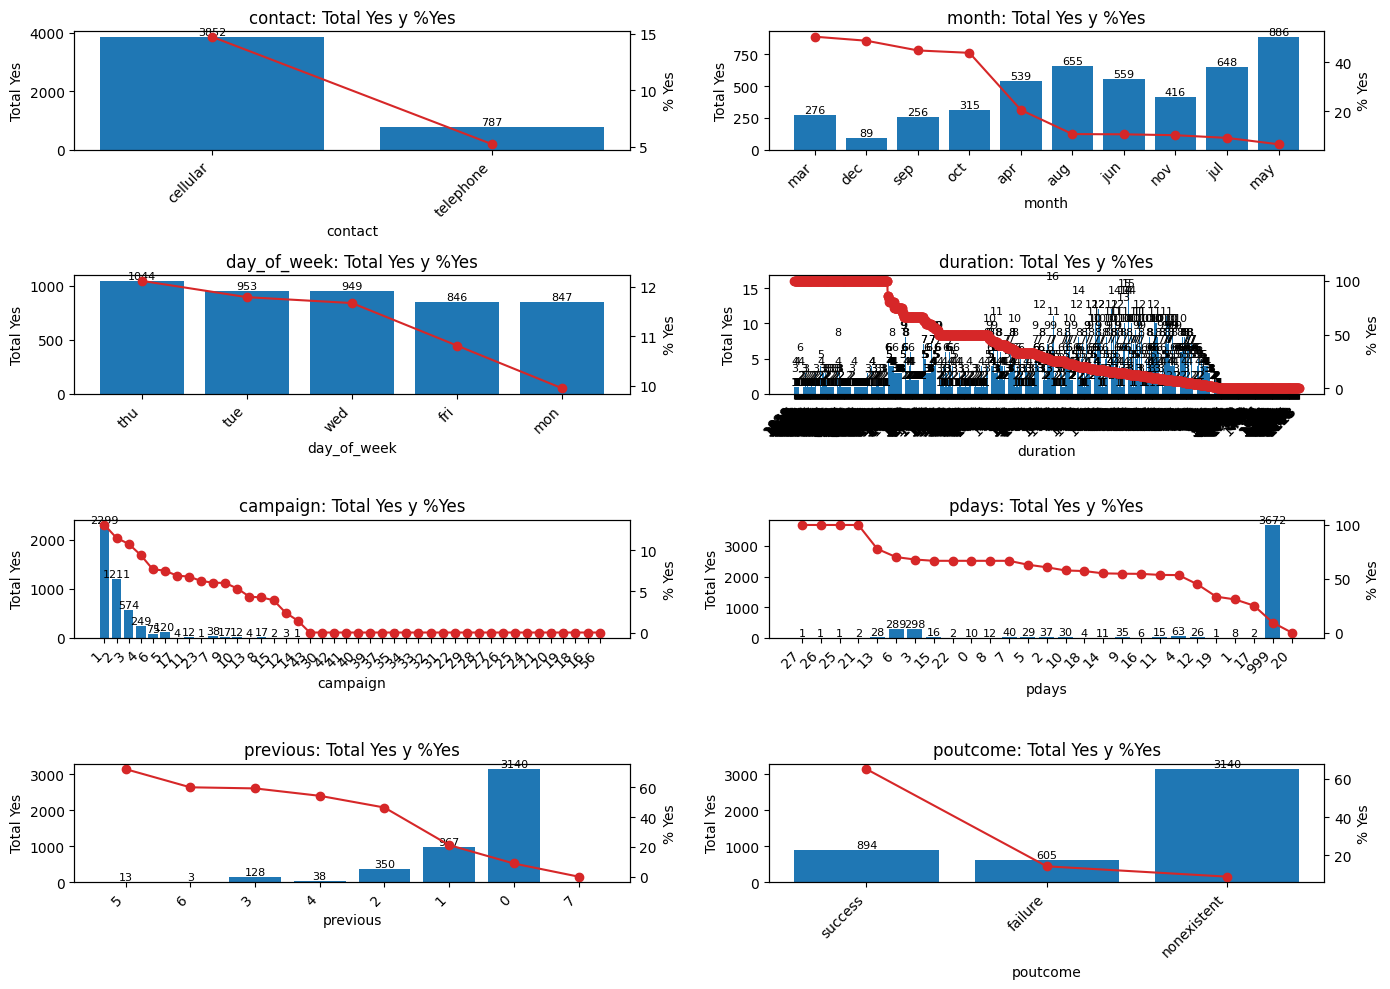

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

# 1) Edad (numérica)
plot_resumen_categorica_ax(df_analisis, "contact", axes[0, 0])

# 2) Job (categórica)
plot_resumen_categorica_ax(df_analisis, "month", axes[0, 1])

# 3) Education (categórica)
plot_resumen_categorica_ax(df_analisis, "day_of_week", axes[1, 0])

# 4) Marital (categórica)
plot_resumen_categorica_ax(df_analisis, "duration", axes[1, 1])

# 1) Edad (numérica)
plot_resumen_categorica_ax(df_analisis, "campaign", axes[2, 0])

# 2) Job (categórica)
plot_resumen_categorica_ax(df_analisis, "pdays", axes[2, 1])

# 3) Education (categórica)
plot_resumen_categorica_ax(df_analisis, "previous", axes[3, 0])

# 4) Marital (categórica)
plot_resumen_categorica_ax(df_analisis, "poutcome", axes[3, 1])

plt.tight_layout()
plt.show()

In [ ]:
# 1) Créditos impagados (default)
_ = conclusiones_categorica(df_analisis, "default")

# 2) Hipoteca (housing)
_ = conclusiones_categorica(df_analisis, "housing")

# 3) Préstamo personal (loan)
_ = conclusiones_categorica(df_analisis, "loan")

### Variable: **default**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `no` (79.1%), `unknown` (20.9%), `yes` (0.0%)
- **Top conversión**: `no` (12.9%), `unknown` (5.2%), `yes` (0.0%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `no` (79.1% del total, 12.9% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `unknown` (20.9% del total, 5.2% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `yes` (0.0% del total, 0.0% conv.)

### Variable: **housing**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `yes` (52.4%), `no` (45.2%), `unknown` (2.4%)
- **Top conversión**: `yes` (11.6%), `no` (10.9%), `unknown` (10.8%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `yes` (52.4% del total, 11.6% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `no` (45.2% del total, 10.9% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `unknown` (2.4% del total, 10.8% conv.)

### Variable: **loan**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `no` (82.4%), `yes` (15.2%), `unknown` (2.4%)
- **Top conversión**: `no` (11.3%), `yes` (10.9%), `unknown` (10.8%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `no` (82.4% del total, 11.3% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `yes` (15.2% del total, 10.9% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `unknown` (2.4% del total, 10.8% conv.)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- Características de la campaña de marketing ---

# fig, axes = plt.subplots(4, 2, figsize=(16, 18))

# # 1) Contact (categórica)
# sns.countplot(x="contact", data=df_tfm_inicial,
#               order=df_tfm_inicial["contact"].value_counts().index,
#               palette="pastel", edgecolor="black", ax=axes[0,0])
# axes[0,0].set_title("Distribución de contact")

# # 2) Month (categórica)
# sns.countplot(x="month", data=df_tfm_inicial,
#               order=df_tfm_inicial["month"].value_counts().index,
#               palette="pastel", edgecolor="black", ax=axes[0,1])
# axes[0,1].set_title("Distribución de month")

# # 3) Day_of_week (categórica)
# sns.countplot(x="day_of_week", data=df_tfm_inicial,
#               order=df_tfm_inicial["day_of_week"].value_counts().index,
#               palette="pastel", edgecolor="black", ax=axes[1,0])
# axes[1,0].set_title("Distribución de day_of_week")

# # 4) Duration (numérica)
# sns.histplot(df_tfm_inicial["duration"], bins=30,
#              color="skyblue", edgecolor="black", ax=axes[1,1])
# axes[1,1].set_title("Distribución de duration")

# # 5) Campaign (numérica)
# sns.histplot(df_tfm_inicial["campaign"], bins=30,
#              color="skyblue", edgecolor="black", ax=axes[2,0])
# axes[2,0].set_title("Distribución de campaign")

# # 6) Pdays (numérica, recortando outlier 999 para visualizar mejor)
# sns.histplot(df_tfm_inicial.loc[df_tfm_inicial["pdays"] != 999, "pdays"],
#              bins=30, color="skyblue", edgecolor="black", ax=axes[2,1])
# axes[2,1].set_title("Distribución de pdays (excluyendo 999)")

# # 7) Previous (numérica)
# sns.histplot(df_tfm_inicial["previous"], bins=30,
#              color="skyblue", edgecolor="black", ax=axes[3,0])
# axes[3,0].set_title("Distribución de previous")

# # 8) Poutcome (categórica)
# sns.countplot(x="poutcome", data=df_tfm_inicial,
#               order=df_tfm_inicial["poutcome"].value_counts().index,
#               palette="pastel", edgecolor="black", ax=axes[3,1])
# axes[3,1].set_title("Distribución de poutcome")

# plt.tight_layout()
# plt.show()

## 2.4. Indicadores macroeconómicos

- `emp.var.rate` -> Tasa de variación del empleo (trimestral).  
- `cons.price.idx` -> Índice de precios al consumidor (mensual).  
- `cons.conf.idx` -> Índice de confianza del consumidor (mensual).  
- `euribor3m` -> Tipo de interés Euribor a 3 meses (diario).  
- `nr.employed` -> Número de empleados (trimestral).  

---

## Hipótesis de cada variable

**Tasa de variación del empleo (emp.var.rate)**: Refleja la situación del mercado laboral.  
- Hipótesis:  
  - Valores positivos -> mayor confianza económica, más probabilidad de inversión.  
  - Valores negativos -> menor predisposición a contratar.  

**Índice de precios al consumidor (cons.price.idx)**: Mide la inflación.  
- Hipótesis:  
  - Inflación moderada -> estabilidad percibida, posible incentivo a invertir.  
  - Inflación elevada -> menor propensión a contratar depósitos.  

**Índice de confianza del consumidor (cons.conf.idx)**: Mide la percepción económica.  
- Hipótesis:  
  - Valores más altos (menos negativos) -> mayor confianza y predisposición.  
  - Valores muy negativos -> menor tasa de conversión.  

**Euribor 3 meses (euribor3m)**: Tipo de interés de referencia.  
- Hipótesis:  
  - Euribor alto -> depósitos más atractivos (mayor rentabilidad).  
  - Euribor bajo -> menor atractivo relativo.  

**Número de empleados (nr.employed)**: Representa la situación global de empleo.  
- Hipótesis:  
  - Niveles altos de empleo -> estabilidad económica y mayor disposición a contratar.  
  - Niveles bajos -> incertidumbre, menor probabilidad de conversión.  

 *A continuación se presentan los gráficos de distribución de los indicadores macroeconómicos.* 

### Análisis de emp.var.rate

emp.var.rate
 1.4    0.394
-1.8    0.223
 1.1    0.189
-0.1    0.089
-2.9    0.040
-3.4    0.026
-1.7    0.019
-1.1    0.015
-3.0    0.004
-0.2    0.000
Name: proportion, dtype: float64


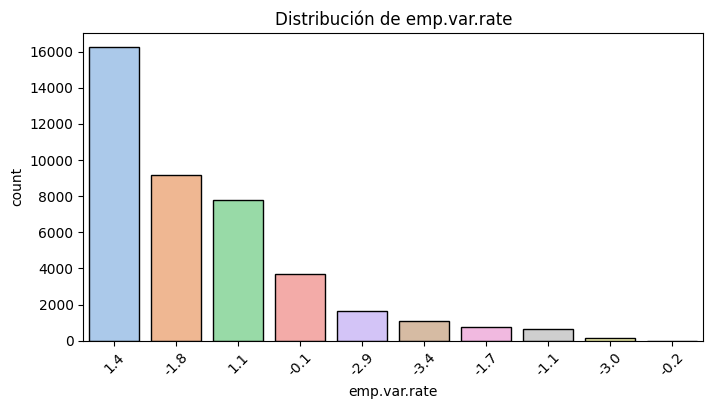

### Análisis de cons.price.idx

cons.price.idx
93.994    0.189
93.918    0.162
92.893    0.141
93.444    0.126
94.465    0.106
93.200    0.088
93.075    0.060
92.201    0.019
92.963    0.017
92.431    0.011
92.649    0.009
94.215    0.008
94.199    0.007
92.843    0.007
92.379    0.006
93.369    0.006
94.027    0.006
94.055    0.006
93.876    0.005
94.601    0.005
92.469    0.004
93.749    0.004
92.713    0.004
94.767    0.003
93.798    0.002
92.756    0.000
Name: proportion, dtype: float64


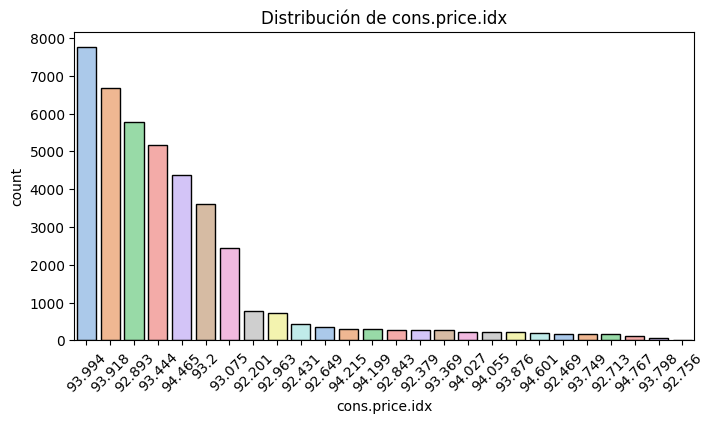

### Análisis de day_of_week

day_of_week
thu    0.209
mon    0.207
wed    0.198
tue    0.196
fri    0.190
Name: proportion, dtype: float64


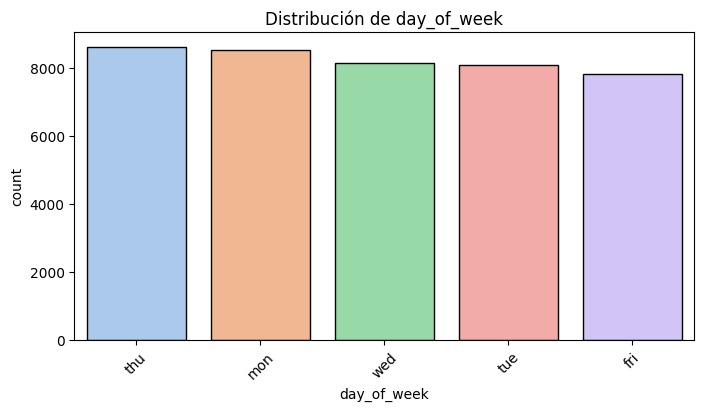

### Análisis de cons.conf.idx

cons.conf.idx
-36.4    0.189
-42.7    0.162
-46.2    0.141
-36.1    0.126
-41.8    0.106
-42.0    0.088
-47.1    0.060
-31.4    0.019
-40.8    0.017
-26.9    0.011
-30.1    0.009
-40.3    0.008
-37.5    0.007
-50.0    0.007
-29.8    0.006
-34.8    0.006
-38.3    0.006
-39.8    0.006
-40.0    0.005
-49.5    0.005
-33.6    0.004
-34.6    0.004
-33.0    0.004
-50.8    0.003
-40.4    0.002
-45.9    0.000
Name: proportion, dtype: float64


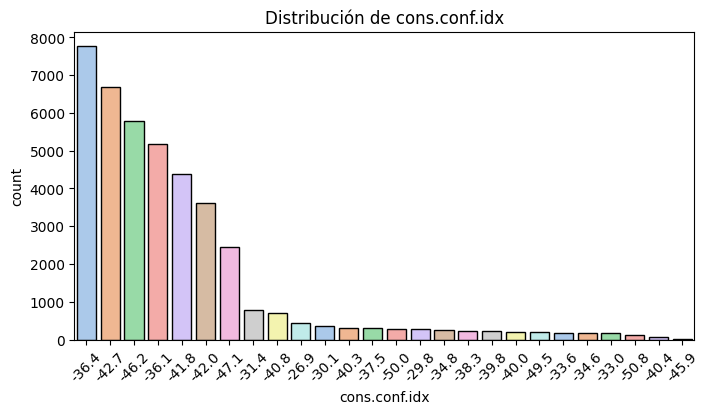

### Análisis de pdays

pdays
999    0.963
3      0.011
6      0.010
4      0.003
9      0.002
2      0.001
7      0.001
12     0.001
10     0.001
5      0.001
13     0.001
11     0.001
1      0.001
15     0.001
14     0.000
8      0.000
0      0.000
16     0.000
17     0.000
18     0.000
22     0.000
19     0.000
21     0.000
25     0.000
26     0.000
27     0.000
20     0.000
Name: proportion, dtype: float64


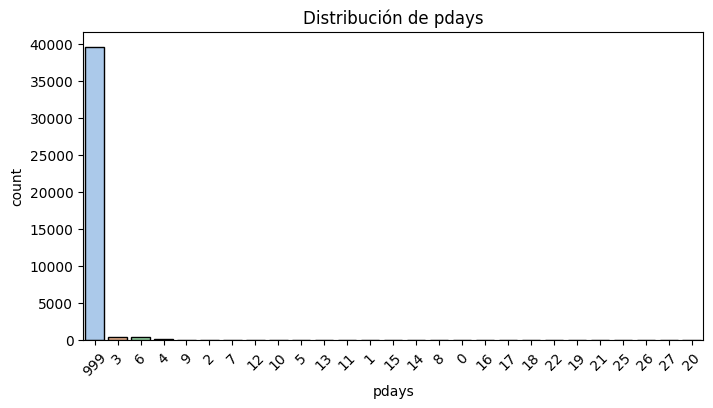

### Análisis de euribor3m

euribor3m
4.857    0.070
4.962    0.063
4.963    0.060
4.961    0.046
4.856    0.029
         ...  
3.853    0.000
3.901    0.000
0.969    0.000
0.956    0.000
3.669    0.000
Name: proportion, Length: 316, dtype: float64


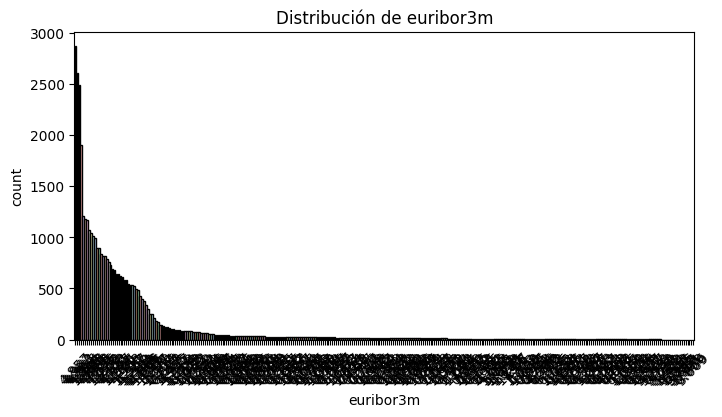

### Análisis de nr.employed

nr.employed
5228.1    0.394
5099.1    0.207
5191.0    0.189
5195.8    0.089
5076.2    0.040
5017.5    0.026
4991.6    0.019
5008.7    0.016
4963.6    0.015
5023.5    0.004
5176.3    0.000
Name: proportion, dtype: float64


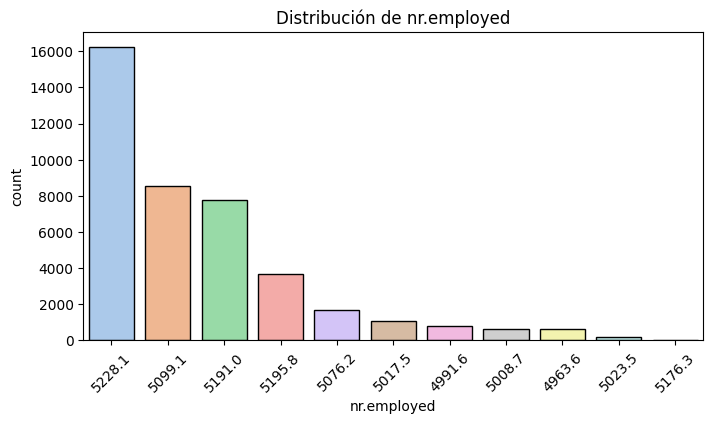

In [ ]:
# Distribución de categorías: 

_ = variable_categorica(df_analisis, "emp.var.rate")

_ = variable_categorica(df_analisis, "cons.price.idx")

_ = variable_categorica(df_analisis, "day_of_week")

#_ = variable_numerica(df_analisis, "cons.conf.idx", bins=10)

_ = variable_categorica(df_analisis, "cons.conf.idx")

_ = variable_categorica(df_analisis, "pdays")

_ = variable_categorica(df_analisis, "euribor3m")

_ = variable_categorica(df_analisis, "nr.employed")

In [ ]:
# ==============================
# Análisis Variables de Campaña
# ==============================

# Edad (agurpada por generación)
print("### Edad (age)")
display(resumen_categorica(df_analisis, "generation")) 

# Tipo de trabajo (categórica)
print("### Tipo de Trabajo (job)")
display(resumen_categorica(df_analisis, "job"))

# Estado civil (categórica)
print("### Estado Civil (marital)")
display(resumen_categorica(df_analisis, "marital"))

# Nivel educativo (categórica)
print("### Nivel Educativo (education)")
display(resumen_categorica(df_analisis, "education"))

### Edad (age)


,generation,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,Other,2,2,100.000000,0.004857
1,Silent Generation (<97),148,75,50.675676,0.359433
2,Baby Boomers (<79),759,337,44.400527,1.843307
3,Gen Z (<28),4214,736,17.465591,10.234117
4,Millennials (<44),24032,2354,9.795273,58.364096
5,Gen X (<60),12021,1135,9.441810,29.194191


### Tipo de Trabajo (job)


,job,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,student,875,275,31.428571,2.125024
1,retired,1718,434,25.261932,4.172333
2,unemployed,1014,144,14.201183,2.462600
3,admin.,10419,1351,12.966695,25.303575
4,management,2924,328,11.217510,7.101224
5,unknown,330,37,11.212121,0.801438
6,technician,6739,730,10.832468,16.366330
7,self-employed,1421,149,10.485574,3.451039
8,housemaid,1060,106,10.000000,2.574315
9,entrepreneur,1456,124,8.516484,3.536040


### Estado Civil (marital)


,marital,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,unknown,80,12,15.000000,0.194288
1,single,11564,1620,14.008993,28.084321
2,divorced,4611,476,10.323140,11.198271
3,married,24921,2531,10.156093,60.523120


### Nivel Educativo (education)


,education,total_registros,total_yes,porcentaje_yes,porcentaje_total
0,illiterate,18,4,22.222222,0.043715
1,unknown,1730,251,14.508671,4.201477
2,university.degree,12164,1669,13.720816,29.541480
3,professional.course,5240,595,11.354962,12.725860
4,high.school,9512,1031,10.838940,23.100835
5,basic.4y,4176,428,10.249042,10.141830
6,basic.6y,2291,188,8.206024,5.563921
7,basic.9y,6045,473,7.824648,14.680882


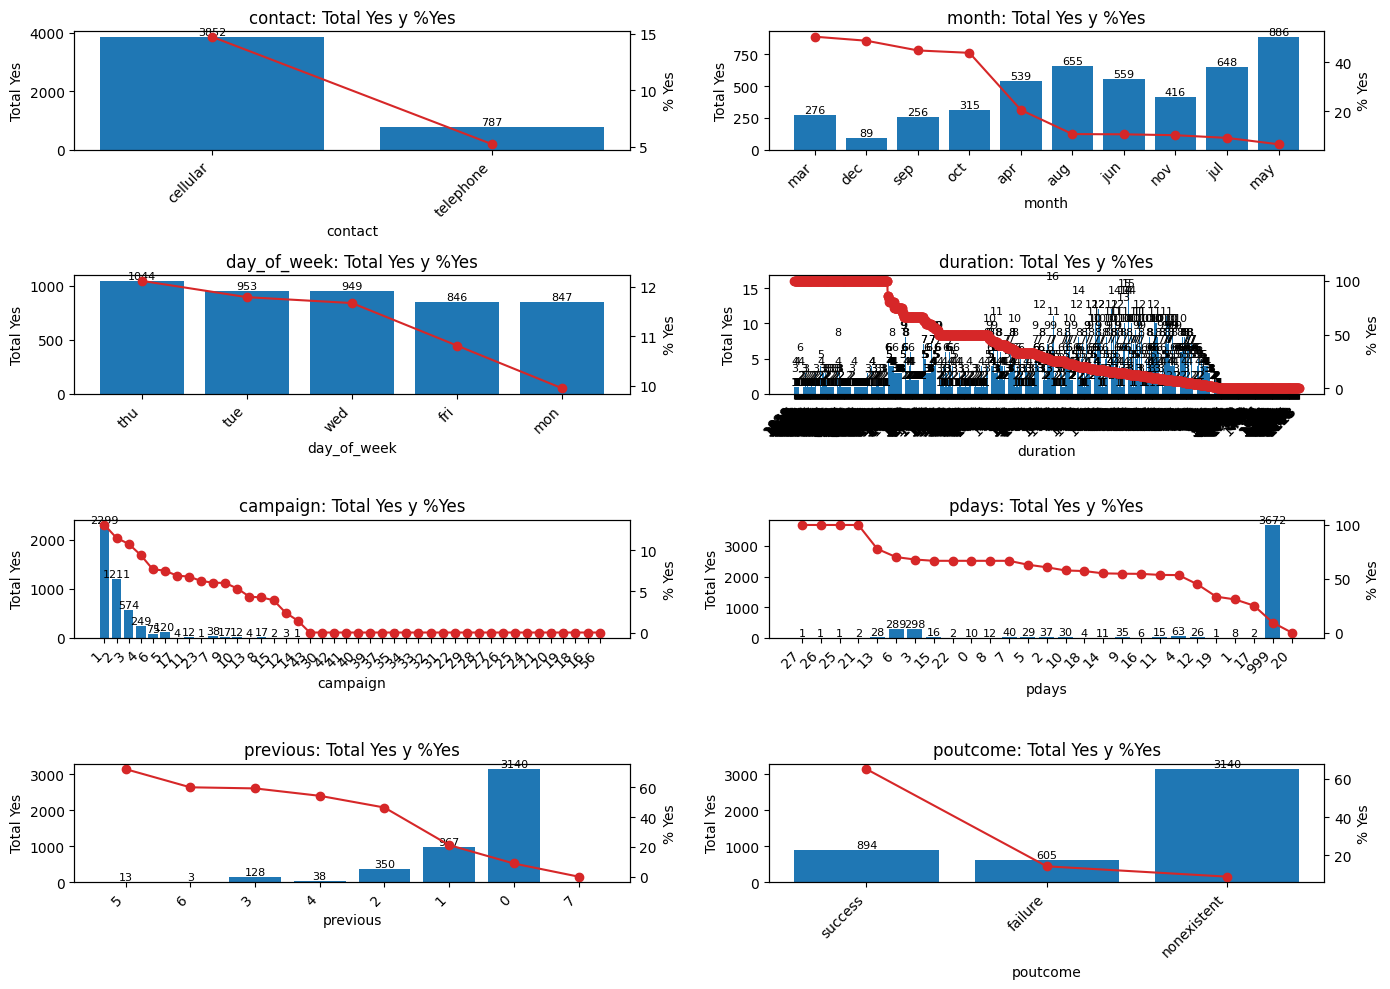

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

# 1) Edad (numérica)
plot_resumen_categorica_ax(df_analisis, "contact", axes[0, 0])

# 2) Job (categórica)
plot_resumen_categorica_ax(df_analisis, "month", axes[0, 1])

# 3) Education (categórica)
plot_resumen_categorica_ax(df_analisis, "day_of_week", axes[1, 0])

# 4) Marital (categórica)
plot_resumen_categorica_ax(df_analisis, "duration", axes[1, 1])

# 1) Edad (numérica)
plot_resumen_categorica_ax(df_analisis, "campaign", axes[2, 0])

# 2) Job (categórica)
plot_resumen_categorica_ax(df_analisis, "pdays", axes[2, 1])

# 3) Education (categórica)
plot_resumen_categorica_ax(df_analisis, "previous", axes[3, 0])

# 4) Marital (categórica)
plot_resumen_categorica_ax(df_analisis, "poutcome", axes[3, 1])

plt.tight_layout()
plt.show()

In [ ]:
# 1) Créditos impagados (default)
_ = conclusiones_categorica(df_analisis, "default")

# 2) Hipoteca (housing)
_ = conclusiones_categorica(df_analisis, "housing")

# 3) Préstamo personal (loan)
_ = conclusiones_categorica(df_analisis, "loan")

### Variable: **default**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `no` (79.1%), `unknown` (20.9%), `yes` (0.0%)
- **Top conversión**: `no` (12.9%), `unknown` (5.2%), `yes` (0.0%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `no` (79.1% del total, 12.9% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `unknown` (20.9% del total, 5.2% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `yes` (0.0% del total, 0.0% conv.)

### Variable: **housing**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `yes` (52.4%), `no` (45.2%), `unknown` (2.4%)
- **Top conversión**: `yes` (11.6%), `no` (10.9%), `unknown` (10.8%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `yes` (52.4% del total, 11.6% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `no` (45.2% del total, 10.9% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `unknown` (2.4% del total, 10.8% conv.)

### Variable: **loan**
#### 📊 Resultados observados
- **Baseline conversión**: 11.3%
- **Top volumen**: `no` (82.4%), `yes` (15.2%), `unknown` (2.4%)
- **Top conversión**: `no` (11.3%), `yes` (10.9%), `unknown` (10.8%)

#### 📈 Interpretación de negocio
- **Segmentos de alto impacto** (volumen alto y conversión > baseline): `no` (82.4% del total, 11.3% conv.)
- **Segmentos a optimizar** (volumen alto pero conversión < baseline): `yes` (15.2% del total, 10.9% conv.)
- **Nichos potencialmente rentables** (volumen bajo pero alta conversión): `unknown` (2.4% del total, 10.8% conv.)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- Indicadores macroeconómicos ---

# macro_vars = [
#     ("emp.var.rate", "Tasa de variación del empleo (trimestral)", "Variación (%)"),
#     ("cons.price.idx", "Índice de precios al consumidor (mensual)", "Índice (base=100)"),
#     ("cons.conf.idx", "Índice de confianza del consumidor (mensual)", "Índice de confianza"),
#     ("euribor3m", "Tipo de interés Euribor a 3 meses (diario)", "Porcentaje (%)"),
#     ("nr.employed", "Número de empleados (trimestral)", "Miles de empleados")
# ]

# fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# for i, (col, title, xlabel) in enumerate(macro_vars):
#     r, c = divmod(i, 2)
#     sns.histplot(df_tfm_inicial[col],
#                  bins=30,
#                  kde=True,
#                  color="skyblue",
#                  edgecolor="black",
#                  ax=axes[r, c])
#     axes[r, c].set_title(f"Distribución de {title}", fontsize=12)
#     axes[r, c].set_xlabel(xlabel, fontsize=10)
#     axes[r, c].set_ylabel("Frecuencia")

# # eliminar el subplot vacío (porque son 5 variables)
# fig.delaxes(axes[2,1])

# plt.tight_layout()
# plt.show()

# 3. Variables Cruzadas

El análisis individual de las variables permite comprender el impacto aislado de cada factor en la contratación de un depósito. Sin embargo, la realidad del comportamiento de los clientes es multifactorial: las características demográficas, financieras y de interacción con la campaña se combinan para influir en la decisión final.  

Por ello, en este apartado se presentan las **variables cruzadas**, es decir, combinaciones de dos o más factores que permiten detectar patrones más complejos y generar hipótesis más sólidas sobre el éxito de la campaña.  

---

## 3.1 Demográficos × Financieros  

Este cruce busca relacionar el perfil sociodemográfico del cliente con su situación financiera.  

- `age × default` -> ¿Los jóvenes caen más en impagos?  
- `age × loan` -> ¿Existe una asociación entre edad y créditos personales?  
- `marital × housing` -> ¿Los casados tienden a tener más hipotecas?  
- `education × loan` -> ¿Una mayor educación implica menor uso de préstamos personales?  
- `job × default` -> ¿Qué sectores laborales presentan mayor morosidad?  

**Hipótesis:** la edad, el estado civil, el nivel educativo y la profesión están estrechamente vinculados con el acceso al crédito y la probabilidad de impago.  


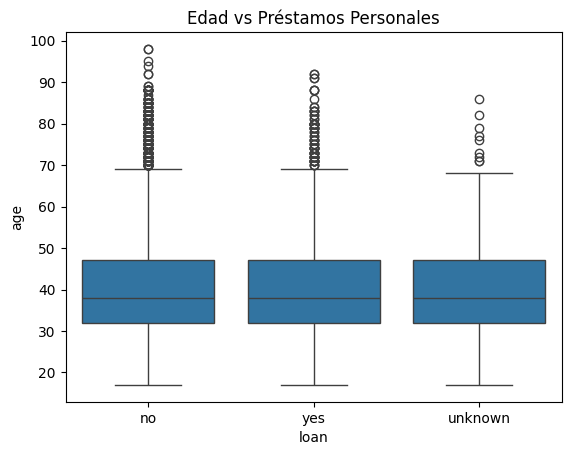

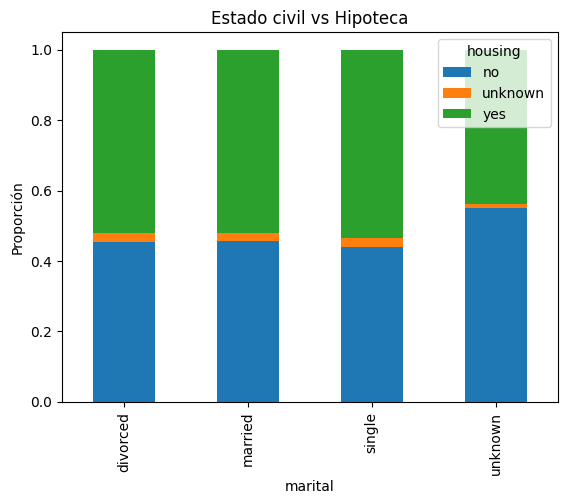

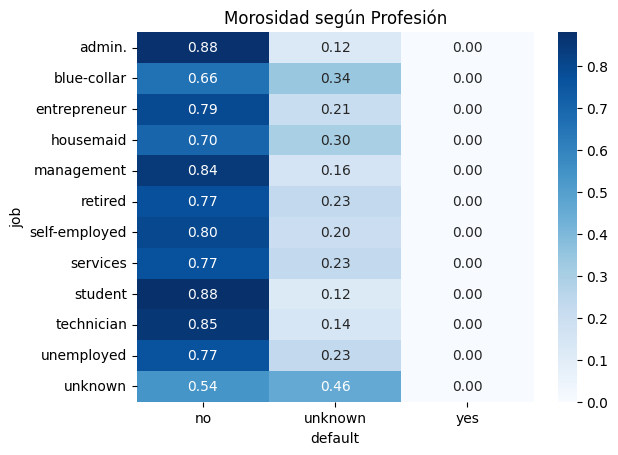

In [ ]:
# Boxplot: edad según préstamos personales
sns.boxplot(x="loan", y="age", data=df_analisis)
plt.title("Edad vs Préstamos Personales")
plt.show()

# Stacked bar: estado civil vs hipoteca
pd.crosstab(df_analisis['marital'], df_analisis['housing'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Estado civil vs Hipoteca")
plt.ylabel("Proporción")
plt.show()

# Heatmap: profesión vs morosidad
cross = pd.crosstab(df_analisis['job'], df_analisis['default'], normalize='index')
sns.heatmap(cross, annot=True, cmap="Blues", fmt=".2f")
plt.title("Morosidad según Profesión")
plt.show()

## 3.2 Demográficos × Campaña actual  

Relaciona el perfil del cliente con la estrategia de contacto utilizada en la campaña actual.  

- `job × duration` -> ¿Se necesita más tiempo para convencer a ciertos trabajos?  
- `education × campaign` -> ¿El nivel educativo influye en la tolerancia a múltiples intentos de contacto?  
- `marital × contact` -> ¿Los casados responden mejor a teléfono fijo y los solteros a móvil?  
- `age × day_of_week` -> ¿Qué día es más efectivo según el grupo etario?  
- `job × month` -> ¿Existen profesiones que reaccionan mejor en determinados meses (ej. funcionarios en junio/diciembre)?  

**Hipótesis:** la efectividad del contacto no solo depende del canal o el momento, sino también del tipo de cliente.  


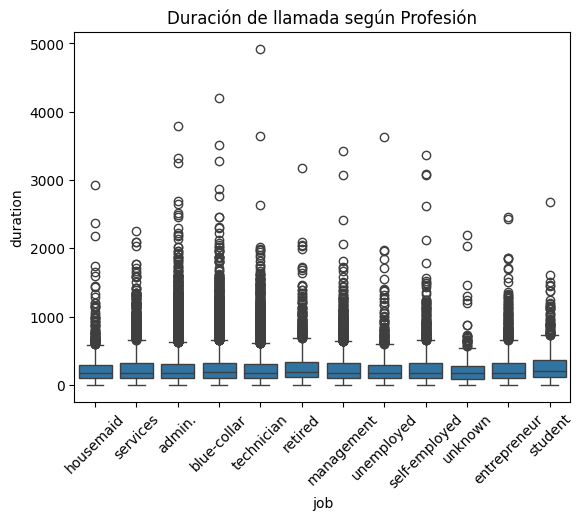

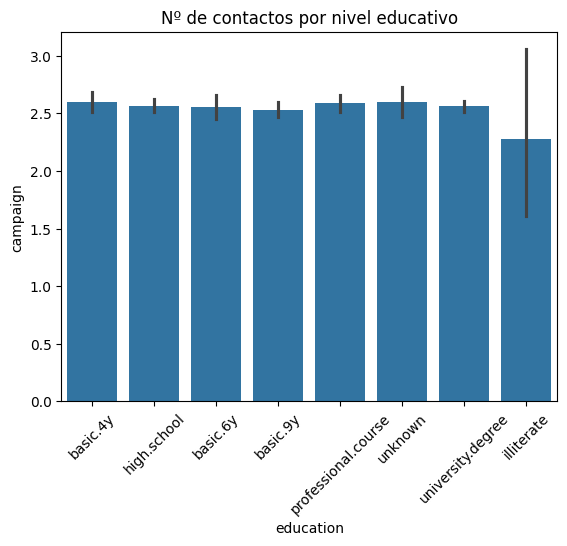

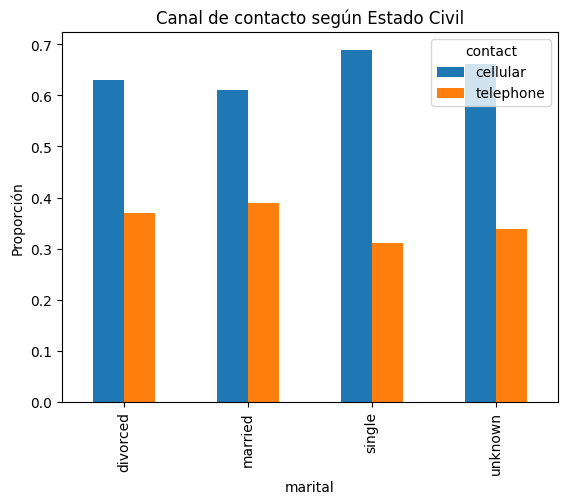

In [ ]:
# Boxplot: duración vs profesión
sns.boxplot(x="job", y="duration", data=df_analisis)
plt.xticks(rotation=45)
plt.title("Duración de llamada según Profesión")
plt.show()

# Bar: número de contactos vs nivel educativo
sns.barplot(x="education", y="campaign", data=df_analisis, estimator=np.mean)
plt.xticks(rotation=45)
plt.title("Nº de contactos por nivel educativo")
plt.show()

# Grouped bar: canal de contacto vs estado civil
pd.crosstab(df_analisis['marital'], df_analisis['contact'], normalize='index').plot(kind='bar')
plt.title("Canal de contacto según Estado Civil")
plt.ylabel("Proporción")
plt.show()

## 3.3 Demográficos × Campañas pasadas  

Analiza cómo el historial de interacción se relaciona con el perfil sociodemográfico.  

- `job × previous` -> ¿Qué profesiones fueron más insistidas en campañas anteriores?  
- `education × poutcome` -> ¿El éxito previo se concentró en clientes con mayor formación?  
- `marital × pdays` -> ¿El estado civil influye en la respuesta según la cercanía del último contacto?  
- `age × poutcome` -> ¿Los jóvenes o mayores responden mejor tras un éxito pasado?  

**Hipótesis:** el recuerdo de campañas anteriores varía según edad, nivel educativo, estado civil y profesión.  

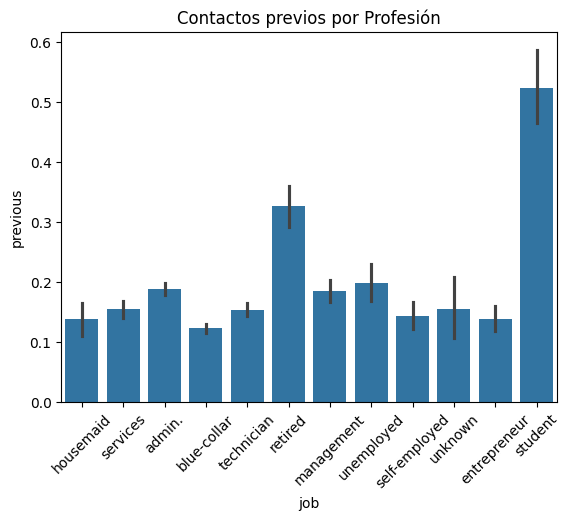

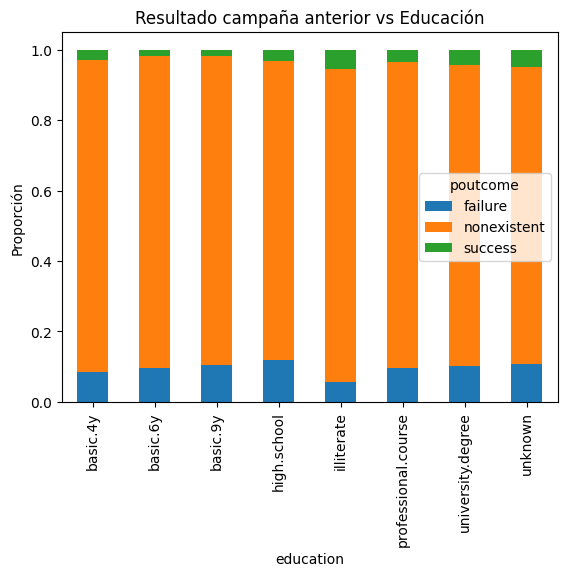

In [ ]:
# Bar: contactos previos vs profesión
sns.barplot(x="job", y="previous", data=df_analisis, estimator=np.mean)
plt.xticks(rotation=45)
plt.title("Contactos previos por Profesión")
plt.show()

# Stacked bar: educación vs resultado anterior
pd.crosstab(df_analisis['education'], df_analisis['poutcome'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Resultado campaña anterior vs Educación")
plt.ylabel("Proporción")
plt.show()

## 3.4 Financieros × Campaña actual  

Permite evaluar cómo la situación económica del cliente influye en la forma y efectividad de los contactos actuales.  

- `housing × campaign` -> ¿A los hipotecados se les insiste más veces en la campaña?  
- `loan × duration` -> ¿Los deudores necesitan más tiempo de persuasión?  
- `default × contact` -> ¿Los morosos son contactados preferentemente por un canal específico?  
- `housing × month` -> ¿Los hipotecados son contactados más en meses clave?  

**Hipótesis:** la situación financiera condiciona tanto la estrategia de contacto como la probabilidad de respuesta.  

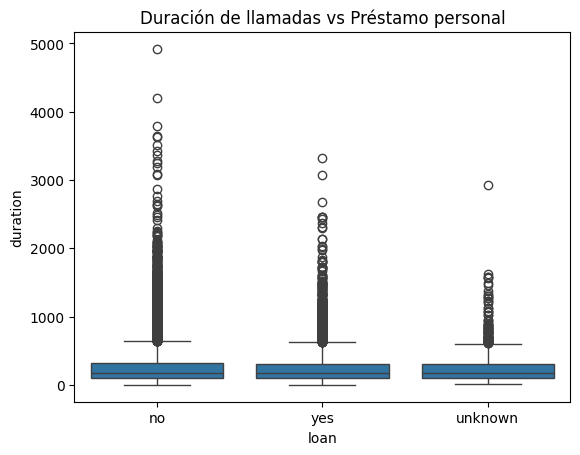

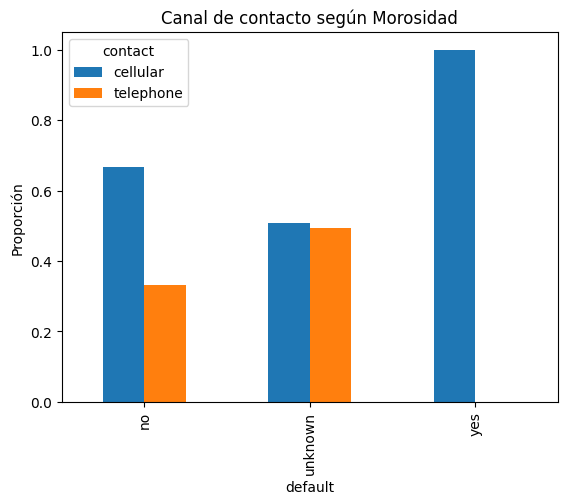

In [ ]:
# Boxplot: duración de llamadas según préstamos
sns.boxplot(x="loan", y="duration", data=df_analisis)
plt.title("Duración de llamadas vs Préstamo personal")
plt.show()

# Grouped bar: canal según morosidad
pd.crosstab(df_analisis['default'], df_analisis['contact'], normalize='index').plot(kind='bar')
plt.title("Canal de contacto según Morosidad")
plt.ylabel("Proporción")
plt.show()

## 3.5 Financieros × Campañas pasadas  

Explora si los antecedentes financieros influyen en la persistencia o el resultado de campañas anteriores.  

- `loan × previous` -> ¿Se insistió más en clientes con préstamos personales?  
- `housing × poutcome` -> ¿El éxito previo fue mayor en clientes con hipoteca?  
- `default × pdays` -> ¿Los morosos fueron recontactados más rápidamente?  

**Hipótesis:** la deuda y la morosidad determinan la estrategia de insistencia y la tasa de éxito en campañas sucesivas.  

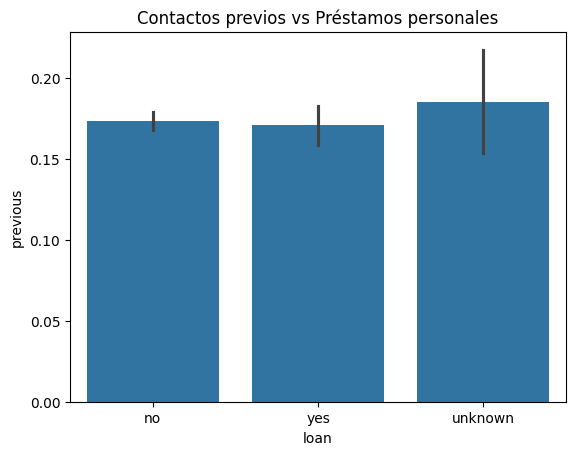

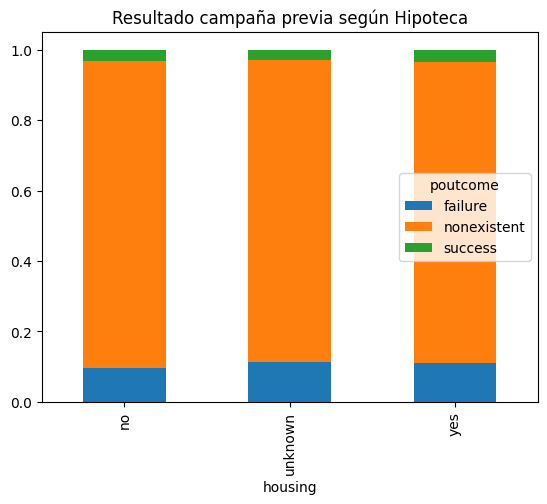

In [ ]:
# Bar: contactos previos según préstamo
sns.barplot(x="loan", y="previous", data=df_analisis, estimator=np.mean)
plt.title("Contactos previos vs Préstamos personales")
plt.show()

# Stacked bar: hipoteca vs resultado previo
pd.crosstab(df_analisis['housing'], df_analisis['poutcome'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Resultado campaña previa según Hipoteca")
plt.show()

## 3.6 Campaña actual × Campañas pasadas  

Relaciona la dinámica de la campaña en curso con la experiencia de interacciones previas.  

- `campaign × previous` -> ¿Existe relación entre el número de intentos actuales y pasados?  
- `duration × poutcome` -> ¿Las campañas previas exitosas se vincularon con llamadas más largas?  
- `month × poutcome` -> ¿Algunos meses presentan mejores resultados históricos?  
- `day_of_week × pdays` -> ¿El día elegido cobra más sentido según la cercanía del último contacto?  

**Hipótesis:** la combinación de persistencia y temporalidad a lo largo de campañas sucesivas condiciona la probabilidad de éxito actual.  

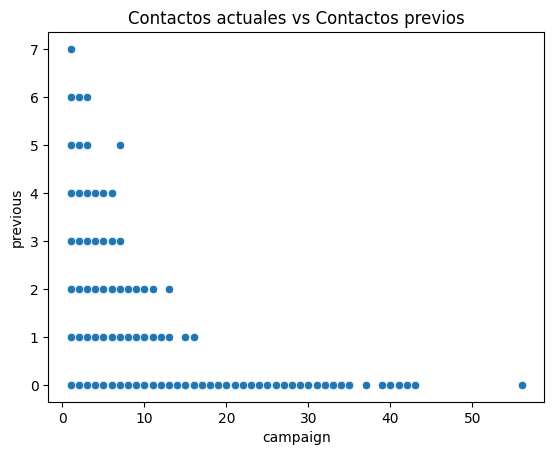

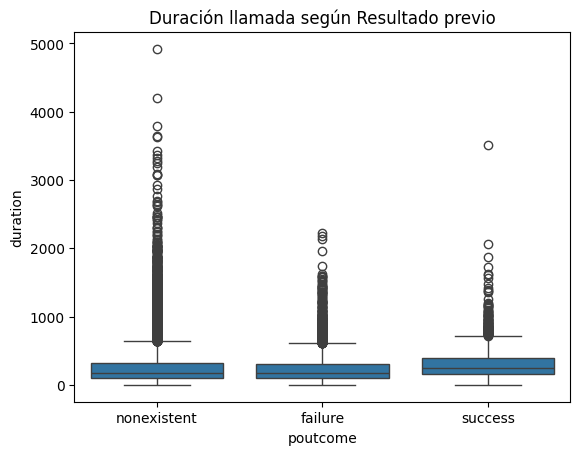

In [ ]:
# Scatter: intentos actuales vs previos
sns.scatterplot(x="campaign", y="previous", data=df_analisis)
plt.title("Contactos actuales vs Contactos previos")
plt.show()

# Boxplot: duración vs resultado previo
sns.boxplot(x="poutcome", y="duration", data=df_analisis)
plt.title("Duración llamada según Resultado previo")
plt.show()

## 3.7 Multicruces (tres o más variables)  

Algunas interacciones requieren considerar simultáneamente múltiples factores para captar patrones complejos.  

- `job × age × housing` -> Identificar el perfil laboral según edad e hipoteca.  
- `education × duration × y` -> ¿El impacto de la duración de la llamada varía según el nivel educativo?  
- `marital × loan × poutcome` -> ¿Estado civil y deuda afectan al éxito pasado?  
- `age × campaign × y` -> ¿La edad influye en el número de intentos necesarios para lograr éxito?  
- `job × contact × y` -> ¿El canal más eficaz depende de la profesión?  

**Hipótesis:** los patrones de conversión son multifactoriales y requieren análisis simultáneo de diversas dimensiones. 

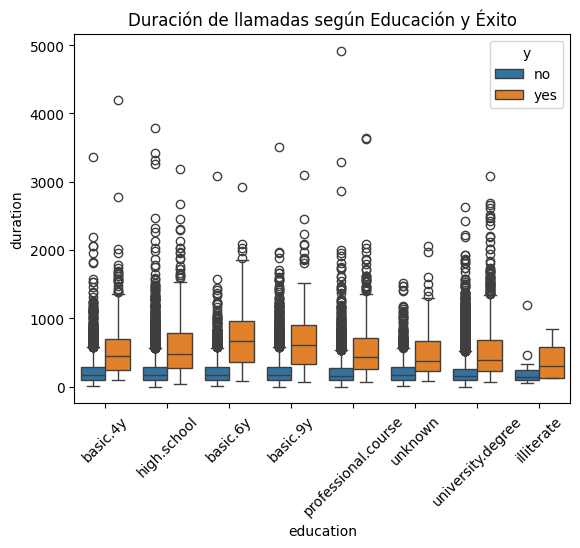

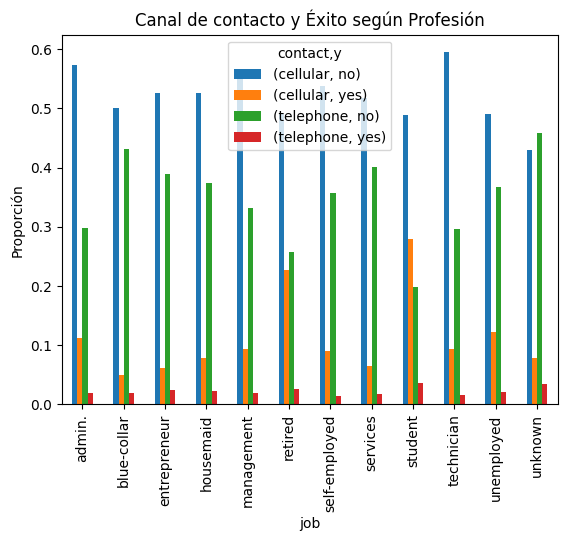

In [ ]:
# Boxplot: duración vs educación, separado por éxito
sns.boxplot(x="education", y="duration", hue="y", data=df_analisis)
plt.xticks(rotation=45)
plt.title("Duración de llamadas según Educación y Éxito")
plt.show()

# Grouped bar: canal vs profesión según éxito
pd.crosstab(df_analisis['job'], [df_analisis['contact'], df_analisis['y']], normalize='index').plot(kind='bar')
plt.title("Canal de contacto y Éxito según Profesión")
plt.ylabel("Proporción")
plt.show()


# 4. Modelos predictivos de conversión (usando `df_analisis`)

En esta sección construiremos modelos de predicción para estimar la probabilidad de conversión de un cliente (`y = yes`).  
Antes de entrenar, realizaremos un análisis de **posibles sesgos** en los datos.



## 4.1 Análisis de sesgos en los datos

Es importante revisar los **sesgos** del dataset antes de modelar:
- **Desbalance de clases** en la variable objetivo `y` (muchos más "no" que "yes").  
- **Categorías con baja frecuencia** en variables categóricas (`job`, `education`, etc.).  
- **Sesgo temporal**: algunas variables como `month` pueden reflejar contextos específicos.  
- **Sesgos socioeconómicos**: edad, educación o tipo de trabajo pueden influir de manera desigual.

A continuación analizamos estos puntos con `df_analisis`.


Dimensiones de df_analisis: (41176, 22)

Columnas: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'generation']

Distribución de y (%):
y
no     88.73
yes    11.27
Name: proportion, dtype: float64


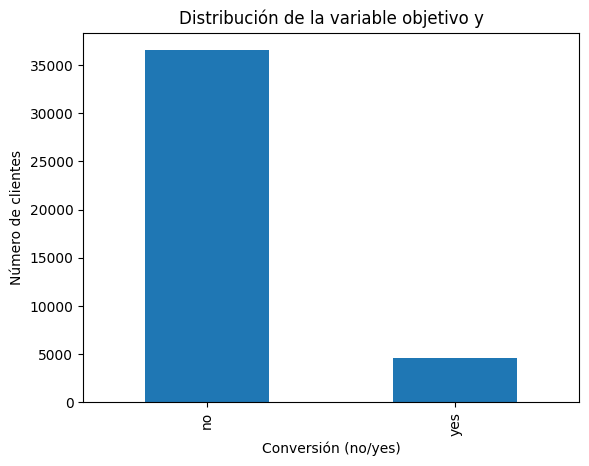


Variables numéricas: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Variables categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'generation']

Columna job: categorías raras (<1% de los datos)
job
unknown    0.8%
Name: proportion, dtype: object

Columna marital: categorías raras (<1% de los datos)
marital
unknown    0.19%
Name: proportion, dtype: object

Columna education: categorías raras (<1% de los datos)
education
illiterate    0.04%
Name: proportion, dtype: object

Columna default: categorías raras (<1% de los datos)
default
yes    0.01%
Name: proportion, dtype: object

Columna month: categorías raras (<1% de los datos)
month
dec    0.44%
Name: proportion, dtype: object

Columna generation: categorías raras (<1% de los datos)
generation
Silent Generation (<97)    0.36%
Other                       0.0%
Name: proportion, dtype:

In [ ]:

# 4.1.1 Comprobación de df_analisis y variable objetivo

if 'df_analisis' not in globals():
    raise ValueError("El DataFrame 'df_analisis' no existe en este notebook.")

print("Dimensiones de df_analisis:", df_analisis.shape)
print("\nColumnas:", df_analisis.columns.tolist())

# Distribución de la variable objetivo y
print("\nDistribución de y (%):")
print((df_analisis['y'].value_counts(normalize=True) * 100).round(2))

# Visualización rápida de balance de clases
import matplotlib.pyplot as plt

df_analisis['y'].value_counts().plot(kind='bar')
plt.title("Distribución de la variable objetivo y")
plt.ylabel("Número de clientes")
plt.xlabel("Conversión (no/yes)")
plt.show()

# Identificar variables numéricas y categóricas
import numpy as np
num_cols = df_analisis.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_analisis.columns if c not in num_cols + ['y']]

print("\nVariables numéricas:", num_cols)
print("\nVariables categóricas:", cat_cols)

# 4.1.2 Categorías con baja frecuencia (<1%)
for col in cat_cols:
    freqs = df_analisis[col].value_counts(normalize=True)
    rare = freqs[freqs < 0.01]
    if not rare.empty:
        print(f"\nColumna {col}: categorías raras (<1% de los datos)")
        print((rare * 100).round(2).astype(str) + "%")


#### 4.2.1 Ajuste del desbalance de clases (Oversampling)

Tras dividir el dataset en entrenamiento y test (4.2), obserse procederá que la variable objetivo y está desbalanceada: hay muchos más registros de la clase no que de la clase yes. Este desbalance puede hacer que los modelos favorezcan la clase mayoritaria y no detecten correctamente los casos positivos, que son los más relevantes para el negocio.

Para mitigarlo aplicamos oversampling con RandomOverSampler (librería imblearn) solo sobre el conjunto de entrenamiento. Concretamente:
	•	Partimos de X_train y y_train.
	•	Aplicamos RandomOverSampler(random_state=42) para replicar aleatoriamente ejemplos de la clase minoritaria hasta equilibrar las clases.
	•	Obtenemos un conjunto balanceado X_train_res y y_train_res (≈ 50/50).
	•	Entrenamos los modelos con X_train_res, y_train_res, y evaluamos siempre en X_test, y_test, que conservan la distribución real.

Este procedimiento garantiza que el modelo vea suficientes positivos durante el entrenamiento sin alterar la evaluación, que sigue siendo honesta y representativa del rendimiento en datos reales.

Nota: el oversampling nunca debe aplicarse sobre test (ni sobre validación fuera de un pipeline) para evitar fuga de información. Además, al duplicar ejemplos puede aumentar el riesgo de sobreajuste; por ello se fija random_state y se evalúa siempre en test intacto.

Tamaños:
X_train: (28823, 22)  | X_test: (12353, 22)
Distribución y_train (%): {0: 88.73, 1: 11.27}

Después de oversampling (train):
y
0    25576
1    25576
Name: count, dtype: int64


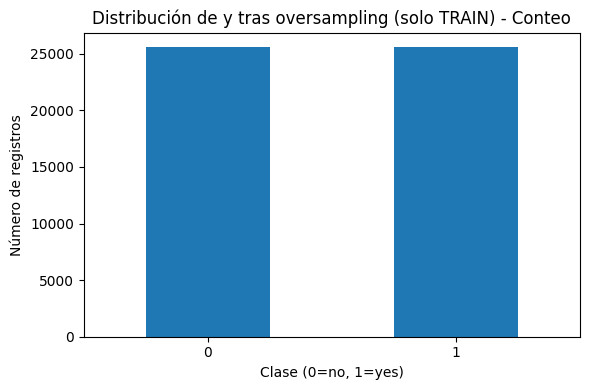

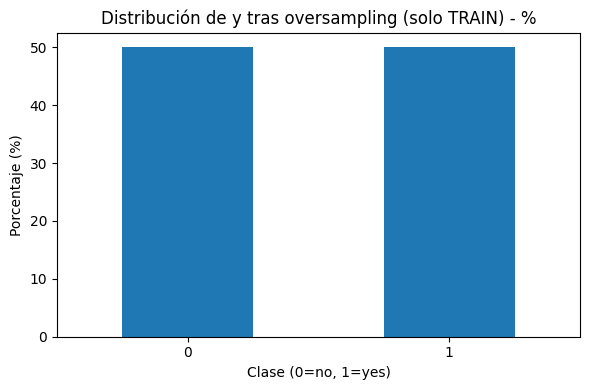

In [ ]:
# 4.2.1 Split estratificado + Oversampling SOLO en el TRAIN (autocontenido)

# %pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# --- 1) Validaciones y preparación de X, y ---
if 'df_analisis' not in globals():
    raise ValueError("El DataFrame 'df_analisis' no existe en este notebook. Ejecuta las celdas del EDA previas.")

if 'y' not in df_analisis.columns:
    raise ValueError("La columna objetivo 'y' no existe en df_analisis.")

# Variable objetivo binaria (1=yes, 0=no)
y = (
    df_analisis['y']
    .astype(str).str.lower()
    .map({'yes': 1, 'no': 0})
    .astype(int)
)

# Feature engineering mínimo (opcional pero útil para este dataset):
# bandera de 'fue contactado antes' (pdays=999 -> NO)
if 'pdays' in df_analisis.columns and 'was_contacted_before' not in df_analisis.columns:
    df_analisis['was_contacted_before'] = (df_analisis['pdays'].astype(int) != 999).astype(int)

# Matriz de características
X = df_analisis.drop(columns=['y'])

# --- 2) Split estratificado ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Tamaños:")
print("X_train:", X_train.shape, " | X_test:", X_test.shape)
print("Distribución y_train (%):", (y_train.value_counts(normalize=True)*100).round(2).to_dict())

# --- 3) Oversampling SOLO en el TRAIN ---
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("\nDespués de oversampling (train):")
print(pd.Series(y_train_res).value_counts())

# --- 4) Gráficos de la distribución tras oversampling ---
plt.figure(figsize=(6,4))
pd.Series(y_train_res).value_counts().sort_index().plot(kind="bar")
plt.title("Distribución de y tras oversampling (solo TRAIN) - Conteo")
plt.xlabel("Clase (0=no, 1=yes)")
plt.ylabel("Número de registros")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
(
    pd.Series(y_train_res)
      .value_counts(normalize=True)
      .mul(100)
      .sort_index()
).plot(kind="bar")
plt.title("Distribución de y tras oversampling (solo TRAIN) - %")
plt.xlabel("Clase (0=no, 1=yes)")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Variables creadas por esta celda:
# X_train, y_train, X_test, y_test  -> split original
# X_train_res, y_train_res          -> train balanceado (oversampling)


## 4.2 Preparación de datos

A continuación preparamos los datos de `df_analisis` para el modelado:
- Convertimos `y` a binaria (1=`yes`, 0=`no`).  
- Separamos variables numéricas y categóricas.  
- Dividimos en **train/test** (70/30) manteniendo la proporción de clases.


In [ ]:

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Variable objetivo (binaria)
y = (df_analisis['y'].astype(str).str.lower() == 'yes').astype(int)

# Ingeniería mínima: bandera de contacto previo (pdays=999 -> no contactado)
if 'pdays' in df_analisis.columns and 'was_contacted_before' not in df_analisis.columns:
    df_analisis['was_contacted_before'] = (df_analisis['pdays'].astype(int) != 999).astype(int)

# Matriz de features (no quitamos columnas aquí; el filtrado se hace en el preprocesado)
X = df_analisis.drop(columns=['y'])

# Split estratificado (sin oversampling aquí)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Tamaños:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Distribución y_train (%):", (y_train.value_counts(normalize=True) * 100).round(2).to_dict())


Tamaños:
X_train: (28823, 22) X_test: (12353, 22)
Distribución y_train (%): {0: 88.73, 1: 11.27}


In [ ]:
from sklearn.model_selection import train_test_split

# Variable objetivo binaria
y = (
    df_analisis['y']
    .astype(str).str.lower()
    .map({'yes': 1, 'no': 0})
    .astype(int)
)

X = df_analisis.drop(columns=['y'])

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Distribución original y_train (%):")
print((y_train.value_counts(normalize=True) * 100).round(2))

Distribución original y_train (%):
y
0    88.73
1    11.27
Name: proportion, dtype: float64



## 4.3 Modelos a entrenar (4.4 - 4.5 - 4.6 - 4.7 - 4.8)

### Elección de los modelos de Machine Learning

En este proyecto se han seleccionado **dos modelos principales de aprendizaje supervisado** para abordar el problema de predicción de conversión: **Regresión Logística** y **Árbol de Decisión**.

- **Regresión Logística**  
  Este modelo es uno de los más utilizados en problemas de clasificación binaria, como en el caso (cliente convierte = 1, cliente no convierte = 0). Su ventaja principal es que permite **estimar probabilidades interpretables** y analizar la relación entre cada variable independiente y la respuesta del cliente. Además, al ser un modelo lineal.
  
- **Árbol de Decisión**  
  Se escogió porque, a diferencia de la regresión logística, puede capturar **relaciones no lineales y reglas de decisión más complejas** entre las variables. Los árboles permiten identificar patrones segmentados (ej. grupos de clientes con características específicas que aumentan la probabilidad de conversión) y ofrecen una **visualización intuitiva** de cómo se toman las decisiones. Aunque pueden sobreajustarse, son muy útiles para interpretar la lógica detrás de las predicciones.


### Qué se procederá a hacer
Entrenaremos ambos modelos utilizando el dataset de campañas de marketing, aplicando técnicas de partición de datos (**train/test**) y **validación cruzada**. Posteriormente evaluaremos su rendimiento mediante métricas como **accuracy, precisión, recall, F1-score y curva ROC-AUC**, con el objetivo de comparar su capacidad predictiva y su utilidad práctica.


### Conclusiones esperadas
Tras analizar los resultados, podremos identificar:  
- Si la **regresión logística** resulta más adecuada como herramienta explicativa y de base estadística.  
- Si el **árbol de decisión** ofrece un mejor rendimiento predictivo gracias a su capacidad de detectar interacciones más complejas entre variables.  

De esta manera, podremos determinar **qué modelo es más recomendable en un contexto real de negocio**, teniendo en cuenta tanto la interpretabilidad como la capacidad de predicción.

In [ ]:

# 4.4 Importaciones y utilidades

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, classification_report)
import matplotlib.pyplot as plt

# Utilidad para mostrar tablas con claridad en el notebook
def show(df, name=None):
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        if name is None:
            name = "Tabla"
        display_dataframe_to_user(name, df)
    except Exception:
        try:
            display(df)
        except Exception:
            print(df.head())
            
print("Librerías y utilidades listas.")


Librerías y utilidades listas.


In [ ]:

# 4.5 Pipelines de preprocesado + modelos (con oversampling en el pipeline)

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Oversampling si está disponible
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import RandomOverSampler
    _HAVE_IMBLEARN = True
except Exception as _e:
    print("⚠️ imblearn no disponible. Se usará class_weight='balanced' como alternativa.")
    _HAVE_IMBLEARN = False

# Asegurar listas num/cat y excluir 'duration' para evitar fuga
try:
    num_cols
    cat_cols
except NameError:
    import numpy as np
    num_cols = df_analisis.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df_analisis.columns if c not in num_cols + ['y']]
if 'duration' in num_cols:
    num_cols.remove('duration')

num_cols_use = [c for c in num_cols if c in X_train.columns]
cat_cols_use = [c for c in cat_cols if c in X_train.columns]

# Preprocesado para Regresión Logística (imputación + escalado + OHE)
preprocess_logit = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols_use),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols_use)
    ],
    remainder='drop'
)

# Preprocesado para Random Forest (imputación + OHE; sin escalado)
preprocess_rf = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ]), num_cols_use),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols_use)
    ],
    remainder='drop'
)

logit = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

if _HAVE_IMBLEARN:
    pipe_logit = ImbPipeline(steps=[
        ('preprocess', preprocess_logit),
        ('ros', RandomOverSampler(random_state=42)),
        ('model', logit)
    ])
    pipe_rf = ImbPipeline(steps=[
        ('preprocess', preprocess_rf),
        ('ros', RandomOverSampler(random_state=42)),
        ('model', rf)
    ])
else:
    pipe_logit = Pipeline(steps=[
        ('preprocess', preprocess_logit),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])
    pipe_rf = Pipeline(steps=[
        ('preprocess', preprocess_rf),
        ('model', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight='balanced'))
    ])

print("Pipelines creados (logística y random forest) con manejo de desbalance. 'duration' excluida del modelado.")


Pipelines creados (logística y random forest) con manejo de desbalance. 'duration' excluida del modelado.


In [ ]:

# 4.6 Funciones auxiliares para entrenamiento y evaluación

def evaluate_classifier(pipe, X_train, y_train, X_test, y_test, model_name="Modelo"):
    """Entrena el pipeline, evalúa en test y devuelve métricas y objetos útiles."""
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Probabilidades para AUC/ROC
    try:
        y_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        y_proba = None
        auc = np.nan
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    
    return {
        "model_name": model_name,
        "pipeline": pipe,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "metrics": {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": auc
        },
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

def plot_confusion(cm, title="Matriz de confusión"):
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No', 'Sí'])
    plt.yticks(tick_marks, ['No', 'Sí'])
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def plot_roc(y_test, y_proba, title="Curva ROC"):
    if y_proba is None:
        print("Este modelo no proporciona probabilidades; no se puede trazar ROC.")
        return
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    fig = plt.figure()
    plt.plot(fpr, tpr, label='Modelo')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

print("Funciones auxiliares listas.")


Funciones auxiliares listas.



=== Regresión Logística ===
              precision    recall  f1-score   support

           0      0.950     0.856     0.901     10961
           1      0.362     0.643     0.463      1392

    accuracy                          0.832     12353
   macro avg      0.656     0.750     0.682     12353
weighted avg      0.884     0.832     0.851     12353



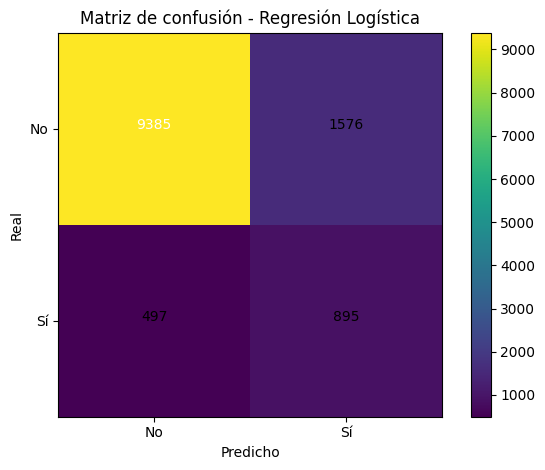

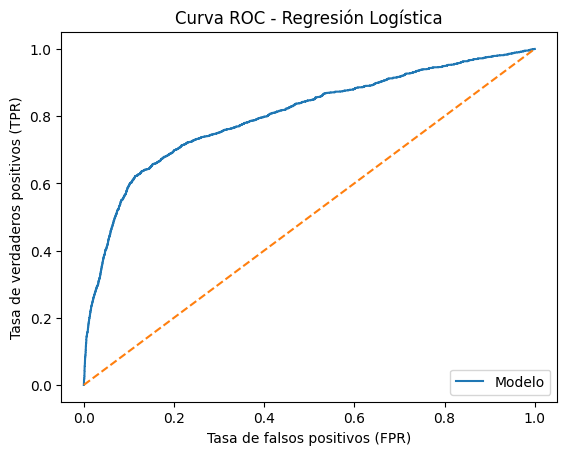


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.922     0.946     0.934     10961
           1      0.462     0.366     0.408      1392

    accuracy                          0.881     12353
   macro avg      0.692     0.656     0.671     12353
weighted avg      0.870     0.881     0.874     12353



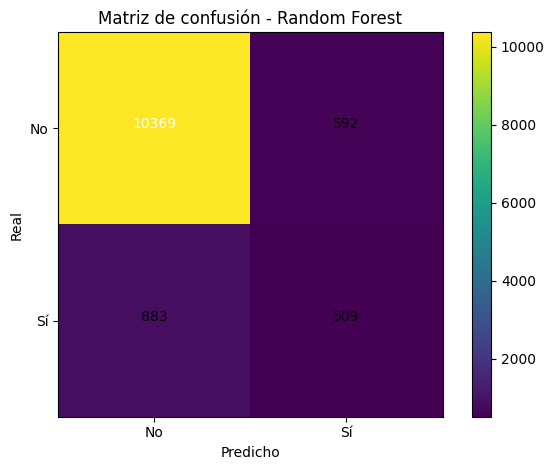

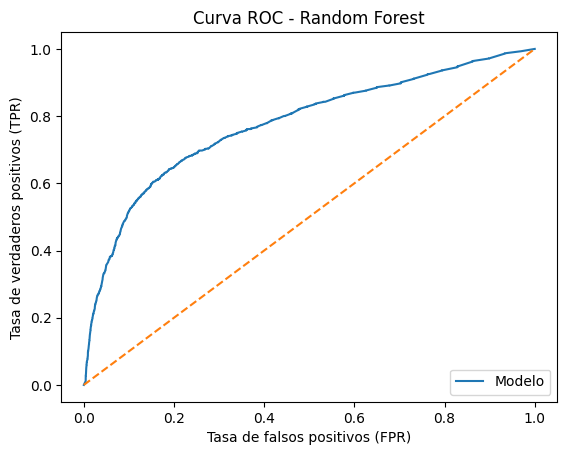

,Modelo,accuracy,precision,recall,f1,roc_auc
0,Regresión Logística,0.832187,0.362202,0.642960,0.463370,0.801783
1,Random Forest,0.880596,0.462307,0.365661,0.408343,0.775847


,Modelo,accuracy,precision,recall,f1,roc_auc
0,Regresión Logística,0.832187,0.362202,0.642960,0.463370,0.801783
1,Random Forest,0.880596,0.462307,0.365661,0.408343,0.775847


In [ ]:

# 4.7 Entrenamiento y evaluación de los dos modelos (oversampling en el pipeline)

results_logit = evaluate_classifier(
    pipe_logit, X_train, y_train, X_test, y_test, 
    model_name="Regresión Logística"
)
plot_confusion(results_logit["confusion_matrix"], title="Matriz de confusión - Regresión Logística")
plot_roc(y_test, results_logit["y_proba"], title="Curva ROC - Regresión Logística")

results_rf = evaluate_classifier(
    pipe_rf, X_train, y_train, X_test, y_test, 
    model_name="Random Forest"
)
plot_confusion(results_rf["confusion_matrix"], title="Matriz de confusión - Random Forest")
plot_roc(y_test, results_rf["y_proba"], title="Curva ROC - Random Forest")

# Tabla comparativa de métricas
comparison = pd.DataFrame([
    {"Modelo": "Regresión Logística", **results_logit["metrics"]},
    {"Modelo": "Random Forest", **results_rf["metrics"]},
])[["Modelo", "accuracy", "precision", "recall", "f1", "roc_auc"]]

try:
    show(comparison, name="Comparativa de métricas (test)")
except Exception:
    pass
comparison


In [ ]:

# === Export métricas 4.7 a CSV ===
from pathlib import Path
_out47 = Path("/Users/ramitafrita/Documents/Master Nuclio Data Analytics/TFM/TFM_Fintechmetrics_4_7.csv")
try:
    comparison.to_csv(_out47, index=False)
    print(f"[OK] Exportado: {_out47}")
    display(comparison)
except NameError:
    print("No se encontró la variable 'comparison'. Ejecuta la celda de 4.7 antes de exportar.")


[OK] Exportado: /Users/ramitafrita/Documents/Master Nuclio Data Analytics/TFM/TFM_Fintechmetrics_4_7.csv


,Modelo,accuracy,precision,recall,f1,roc_auc
0,Regresión Logística,0.832187,0.362202,0.642960,0.463370,0.801783
1,Random Forest,0.880596,0.462307,0.365661,0.408343,0.775847


In [ ]:

# 4.8 Interpretabilidad: Importancia de variables y coeficientes

# Helper: obtener nombres de columnas tras el ColumnTransformer
def get_feature_names_from_column_transformer(ct):
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            try:
                names = transformer.get_feature_names_out(cols)
            except TypeError:
                names = transformer.get_feature_names_out()
            feature_names.extend(names)
        elif transformer == 'passthrough':
            feature_names.extend(cols)
        else:
            if hasattr(transformer, 'steps'):
                last_step = transformer.steps[-1][1]
                if hasattr(last_step, 'get_feature_names_out'):
                    feature_names.extend(last_step.get_feature_names_out(cols))
                else:
                    feature_names.extend(cols)
            else:
                feature_names.extend(cols)
    return np.array(feature_names, dtype=object)

# Random Forest - importancias
rf_pipeline = results_rf["pipeline"]
rf_model = rf_pipeline.named_steps["model"]
rf_ct = rf_pipeline.named_steps["preprocess"]
rf_features = get_feature_names_from_column_transformer(rf_ct)

rf_importances = pd.DataFrame({
    "feature": rf_features,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False).head(25)

show(rf_importances, name="Top 25 Importancias - Random Forest")

# Regresión Logística - odds ratios
logit_pipeline = results_logit["pipeline"]
logit_model = logit_pipeline.named_steps["model"]
logit_ct = logit_pipeline.named_steps["preprocess"]
logit_features = get_feature_names_from_column_transformer(logit_ct)

odds = np.exp(logit_model.coef_[0])
logit_coefs = pd.DataFrame({
    "feature": logit_features,
    "odds_ratio": odds
}).sort_values("odds_ratio", ascending=False).head(25)

show(logit_coefs, name="Top 25 Odds Ratios - Regresión Logística")


,feature,importance
7,euribor3m,0.122906
0,age,0.120760
1,campaign,0.074981
8,nr.employed,0.060410
4,emp.var.rate,0.040369
6,cons.conf.idx,0.027825
5,cons.price.idx,0.022360
36,housing_no,0.019854
38,housing_yes,0.019769
2,pdays,0.018493


,feature,odds_ratio
49,month_mar,3.399554
5,cons.price.idx,2.646877
7,euribor3m,2.053744
67,generation_Silent Generation (<97),1.679789
46,month_dec,1.594827
29,education_illiterate,1.538703
24,marital_unknown,1.530716
45,month_aug,1.503494
14,job_retired,1.477621
61,poutcome_success,1.429835


## 4.8 Análisis de importancia y selección de variables

En este apartado evaluaremos qué variables tienen mayor relevancia en la predicción de la conversión, siguiendo las recomendaciones del tutor.  

### 4.8.1 Importancia de variables en Random Forest
El Random Forest asigna una medida de importancia a cada variable en función de cómo contribuye a reducir la impureza (Gini) en los árboles.  
Esto nos permitirá visualizar qué variables explican mejor la conversión.

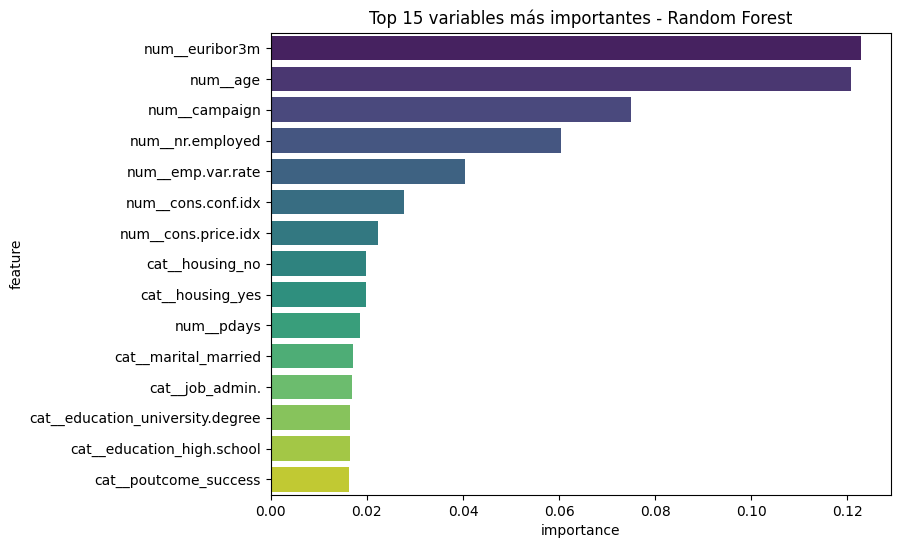

,feature,importance
7,num__euribor3m,0.122906
0,num__age,0.120760
1,num__campaign,0.074981
8,num__nr.employed,0.060410
4,num__emp.var.rate,0.040369
6,num__cons.conf.idx,0.027825
5,num__cons.price.idx,0.022360
36,cat__housing_no,0.019854
38,cat__housing_yes,0.019769
2,num__pdays,0.018493


In [ ]:
# 4.8.1 Importancia de variables en Random Forest
importances = pipe_rf.named_steps['model'].feature_importances_
feature_names = pipe_rf.named_steps['preprocess'].get_feature_names_out()
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_imp, palette="viridis")
plt.title("Top 15 variables más importantes - Random Forest")
plt.show()

feat_imp

### 4.8.2 Coeficientes y p-values en Regresión Logística
La Regresión Logística, además de generar predicciones, nos da información estadística sobre la relación entre cada variable y la probabilidad de conversión.  
Usaremos `statsmodels` para obtener los **coeficientes** y los **p-values**, lo que nos permitirá identificar qué variables son estadísticamente significativas.  



In [ ]:
# 4.8.2 Coeficientes y p-values en Regresión Logística (statsmodels)

import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

# Ajustar OneHotEncoder para evitar colinealidad y obtener salida densa
preprocess_logit_sm = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ]), cat_cols)
    ]
)

# Preprocesar datos
X_train_trans = preprocess_logit_sm.fit_transform(X_train_res)
X_test_trans  = preprocess_logit_sm.transform(X_test)

# Convertir explícitamente a array NumPy
X_train_trans = np.array(X_train_trans)
X_test_trans  = np.array(X_test_trans)

# Ajustar modelo en statsmodels
X_train_const = sm.add_constant(X_train_trans, has_constant='add')
logit_sm = sm.Logit(y_train_res, X_train_const)

try:
    result = logit_sm.fit(maxiter=100, disp=0)
    summary_table = pd.DataFrame({
        "variable": ["const"] + list(preprocess_logit_sm.get_feature_names_out()),
        "coef": result.params,
        "pvalue": result.pvalues,
        "odds_ratio": np.exp(result.params)
    }).sort_values("pvalue").head(20)

    display(summary_table)

except Exception as e:
    print("Error en ajuste clásico, probando versión regularizada...")
    result = logit_sm.fit_regularized(method="l1", maxiter=200)
    summary_table = pd.DataFrame({
        "variable": ["const"] + list(preprocess_logit_sm.get_feature_names_out()),
        "coef": result.params,
        "odds_ratio": np.exp(result.params)
    }).sort_values("coef", key=abs).head(20)

    display(summary_table)

/opt/anaconda3/envs/py313/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,variable,coef,pvalue,odds_ratio
x37,cat__contact_telephone,-0.664625,2.860368e-60,0.514467
x5,num__emp.var.rate,-2.455088,2.016840e-54,0.085856
x42,cat__month_mar,1.391386,6.636348e-42,4.020419
x6,num__cons.price.idx,1.105679,6.783177e-26,3.021276
x55,cat__generation_Millennials (<44),-0.396487,1.431528e-22,0.672679
x43,cat__month_may,-0.417647,7.136627e-20,0.658594
x2,num__campaign,-0.102955,2.128848e-19,0.902168
x41,cat__month_jun,-0.557192,4.926634e-15,0.572815
x44,cat__month_nov,-0.479044,1.061711e-13,0.619375
x3,num__pdays,-0.394183,2.379885e-13,0.674230


### 4.8.3 Comparación entre modelos
- El **Random Forest** prioriza variables más relacionadas con el comportamiento de campaña (ejemplo: duración de la llamada, mes, resultado previo de campañas).  
- La **Regresión Logística** permite entender qué variables socio-demográficas y macroeconómicas influyen más en la conversión, además de confirmar la significancia estadística con p-values.  

In [ ]:
# 4.8.3 Selección de mejores variables (top 10 RF ∪ top 10 Logit) sin asumir nombres de pasos

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer

# --- Asegurar que los modelos están entrenados ---
if not hasattr(pipe_rf, "classes_"):
    pipe_rf.fit(X_train, y_train)
if not hasattr(pipe_logit, "classes_"):
    pipe_logit.fit(X_train, y_train)

# --- Utilidades para encontrar pasos sin suponer nombres ('pre', 'clf', etc.) ---
def find_preprocessor(pipe):
    # busca un ColumnTransformer en los pasos del pipeline (primer nivel)
    for name, step in pipe.named_steps.items():
        if isinstance(step, ColumnTransformer):
            return step
    # si no está a primer nivel, intenta encontrarlo anidado (poco común)
    for name, step in pipe.named_steps.items():
        if hasattr(step, "named_steps"):
            for subname, substep in step.named_steps.items():
                if isinstance(substep, ColumnTransformer):
                    return substep
    raise RuntimeError("No se encontró un ColumnTransformer en el pipeline.")

def find_classifier(pipe):
    # clasificador: tiene predict() y no es ColumnTransformer ni sampler (fit_resample)
    for name, step in pipe.named_steps.items():
        if hasattr(step, "predict") and not isinstance(step, ColumnTransformer) and not hasattr(step, "fit_resample"):
            return step
    # anidado
    for name, step in pipe.named_steps.items():
        if hasattr(step, "named_steps"):
            for subname, substep in step.named_steps.items():
                if hasattr(substep, "predict") and not isinstance(substep, ColumnTransformer) and not hasattr(substep, "fit_resample"):
                    return substep
    raise RuntimeError("No se encontró el clasificador final en el pipeline.")

def get_transformed_feature_names(pre: ColumnTransformer):
    names = []
    for name, trans, cols in pre.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, "get_feature_names_out"):
            fn = trans.get_feature_names_out(cols)
        else:
            fn = np.array(cols, dtype=object)
        names.extend(fn.tolist())
    return np.array(names, dtype=object)

# --- 1) Nombres transformados desde el preprocesador real del pipeline ---
pre = find_preprocessor(pipe_rf)
feat_names_trans = get_transformed_feature_names(pre)

# --- 2) Importancias de RF (en espacio transformado) ---
rf_est = find_classifier(pipe_rf)
if not hasattr(rf_est, "feature_importances_"):
    raise RuntimeError("El clasificador de RF no expone feature_importances_.")
rf_importances = rf_est.feature_importances_
feat_imp_trans = pd.DataFrame({"feature_trans": feat_names_trans,
                               "importance": rf_importances})

# --- 3) Coefs de Logit (magnitud absoluta, en espacio transformado) ---
logit_est = find_classifier(pipe_logit)
if not hasattr(logit_est, "coef_"):
    raise RuntimeError("El clasificador de Logit no expone coef_.")
logit_coefs = logit_est.coef_.ravel()
coef_imp_trans = pd.DataFrame({"feature_trans": feat_names_trans,
                               "coef_abs": np.abs(logit_coefs)})

# --- 4) Mapear cada feature transformada a su columna original (antes de OneHot) ---
# Usamos tus listas previas: num_cols y cat_cols (definidas en 4.1.1)
def base_col_from_trans(feat_name):
    if feat_name in num_cols:
        return feat_name
    for c in cat_cols:
        # separadores comunes generados por OneHotEncoder
        if str(feat_name).startswith(str(c) + "_") or str(feat_name).startswith(str(c) + "=") or str(feat_name).startswith(str(c) + "__"):
            return c
    # fallback: si no detectamos, devolvemos el nombre tal cual (no debería pasar con tus datos)
    return feat_name

feat_imp_trans["base_col"]  = feat_imp_trans["feature_trans"].map(base_col_from_trans)
coef_imp_trans["base_col"]  = coef_imp_trans["feature_trans"].map(base_col_from_trans)

# --- 5) Agregar por columna original (sumar dummies de una misma variable original) ---
rf_by_base    = feat_imp_trans.groupby("base_col", as_index=False)["importance"].sum()
logit_by_base = coef_imp_trans.groupby("base_col", as_index=False)["coef_abs"].sum()

# --- 6) Top-10 por cada modelo (a nivel de columna original) ---
top_rf    = rf_by_base.sort_values("importance", ascending=False).head(10)["base_col"].tolist()
top_logit = logit_by_base.sort_values("coef_abs",   ascending=False).head(10)["base_col"].tolist()

# --- 7) Unión ordenada: primero RF y añadimos las de Logit que falten ---
selected_features = top_rf + [c for c in top_logit if c not in top_rf]

print("Top-10 RF (base cols):", top_rf)
print("Top-10 Logit (base cols):", top_logit)
print("\nVariables seleccionadas (RF ∪ Logit, columnas ORIGINALES):")
print(selected_features)

# --- 8) Conjuntos reducidos en columnas originales (¡ahora sí existen en X!) ---
X_train_sel = X_train[selected_features].copy()
X_test_sel  = X_test[selected_features].copy()
y_train_sel = y_train
y_test_sel  = y_test

Top-10 RF (base cols): ['euribor3m', 'age', 'job', 'education', 'campaign', 'day_of_week', 'nr.employed', 'marital', 'housing', 'emp.var.rate']
Top-10 Logit (base cols): ['month', 'emp.var.rate', 'generation', 'job', 'education', 'cons.price.idx', 'marital', 'poutcome', 'euribor3m', 'contact']

Variables seleccionadas (RF ∪ Logit, columnas ORIGINALES):
['euribor3m', 'age', 'job', 'education', 'campaign', 'day_of_week', 'nr.employed', 'marital', 'housing', 'emp.var.rate', 'month', 'generation', 'cons.price.idx', 'poutcome', 'contact']


In [ ]:
# 4.8.3 Selección de variables (ejemplo)
selected_features = ['age','job','marital','education','campaign']  

# Crear conjuntos reducidos ANTES de oversampling
X_train_sel = X_train[selected_features].copy()
X_test_sel  = X_test[selected_features].copy()

# La y es la misma que en 4.2 (no cambia con la selección de features)
y_train_sel = y_train
y_test_sel  = y_test

### 4.8.4 Reentrenamiento con variables seleccionadas
Finalmente, entrenaremos nuevamente los modelos utilizando únicamente las variables más relevantes (las top 5–10 según importancia/p-value).  
Esto nos permitirá comprobar si el rendimiento se mantiene con menos columnas y, por tanto, justificar qué variables realmente necesitamos para el modelo.


=== Logit reducido (vars seleccionadas) ===
              precision    recall  f1-score   support

           0      0.924     0.607     0.733     10961
           1      0.164     0.608     0.259      1392

    accuracy                          0.607     12353
   macro avg      0.544     0.608     0.496     12353
weighted avg      0.839     0.607     0.680     12353



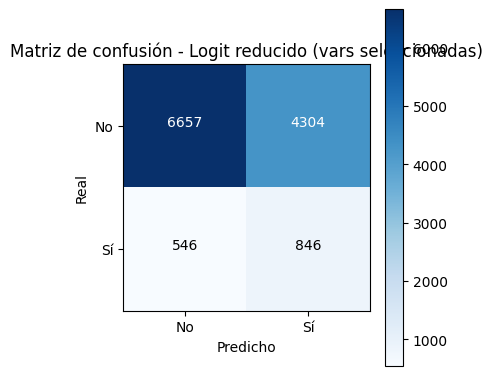

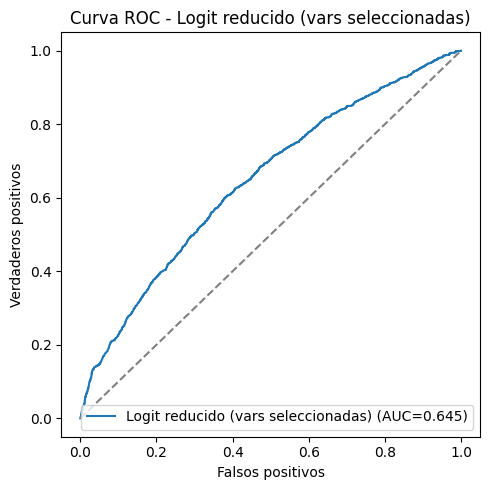


=== Random Forest reducido (vars seleccionadas) ===
              precision    recall  f1-score   support

           0      0.907     0.708     0.795     10961
           1      0.157     0.428     0.230      1392

    accuracy                          0.677     12353
   macro avg      0.532     0.568     0.513     12353
weighted avg      0.823     0.677     0.732     12353



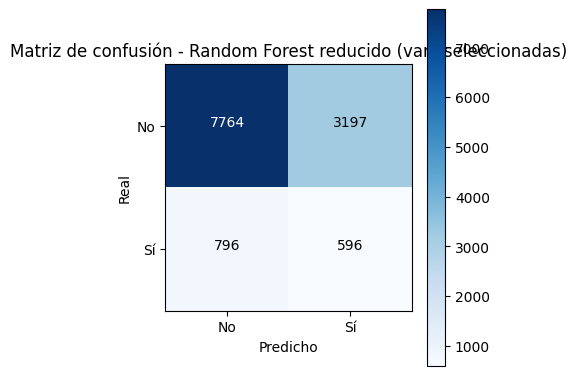

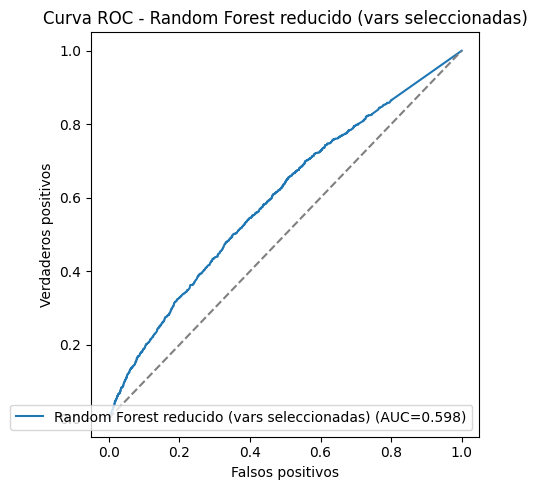

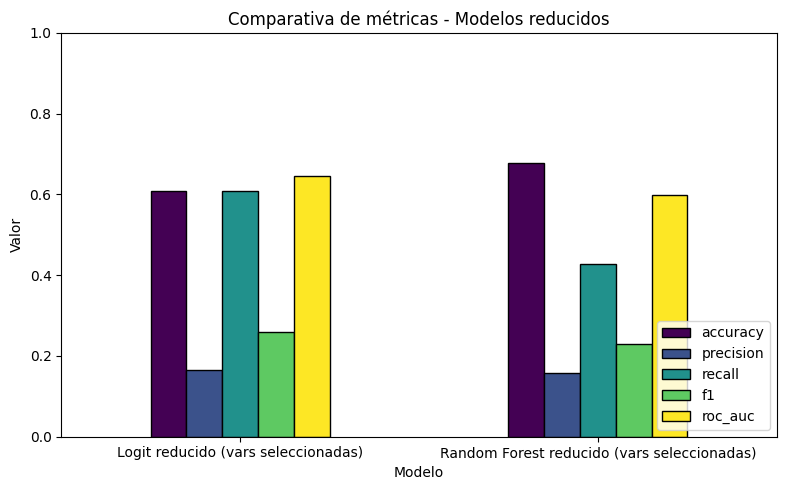

,Modelo,accuracy,precision,recall,f1,roc_auc
0,Logit reducido (vars seleccionadas),0.607383,0.164272,0.607759,0.258637,0.645456
1,Random Forest reducido (vars seleccionadas),0.676759,0.157132,0.428161,0.229894,0.597566


In [ ]:

## 4.8.4 Reentrenamiento con variables seleccionadas (pipelines + ROS en el pipeline)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import RandomOverSampler
    _HAVE_IMBLEARN = True
except Exception:
    _HAVE_IMBLEARN = False

num_sel = [c for c in X_train_sel.columns if c in num_cols]
cat_sel = [c for c in X_train_sel.columns if c in cat_cols]

preprocess_sel_logit = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_sel),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_sel)
    ],
    remainder='drop'
)

preprocess_sel_rf = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ]), num_sel),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_sel)
    ],
    remainder='drop'
)

if _HAVE_IMBLEARN:
    pipe_logit_red = ImbPipeline([('preprocess', preprocess_sel_logit),
                                  ('ros', RandomOverSampler(random_state=42)),
                                  ('model', LogisticRegression(max_iter=1000))])
    pipe_rf_red    = ImbPipeline([('preprocess', preprocess_sel_rf),
                                  ('ros', RandomOverSampler(random_state=42)),
                                  ('model', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))])
else:
    pipe_logit_red = Pipeline([('preprocess', preprocess_sel_logit),
                               ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))])
    pipe_rf_red    = Pipeline([('preprocess', preprocess_sel_rf),
                               ('model', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight='balanced'))])

def evaluate_and_plot(model, X_train, y_train, X_test, y_test, model_name="Modelo reducido"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except Exception:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Matriz de confusión - {model_name}")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No', 'Sí']); plt.yticks(tick_marks, ['No', 'Sí'])
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Real'); plt.xlabel('Predicho'); plt.tight_layout(); plt.show()

    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(5,5))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")
        plt.plot([0,1],[0,1], linestyle="--", color="gray")
        plt.xlabel("Falsos positivos"); plt.ylabel("Verdaderos positivos")
        plt.title(f"Curva ROC - {model_name}")
        plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

    return {"Modelo": model_name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

metrics_logit_sel = evaluate_and_plot(
    pipe_logit_red, X_train_sel, y_train_sel, X_test_sel, y_test_sel, "Logit reducido (vars seleccionadas)"
)
metrics_rf_sel = evaluate_and_plot(
    pipe_rf_red, X_train_sel, y_train_sel, X_test_sel, y_test_sel, "Random Forest reducido (vars seleccionadas)"
)

df_metrics_sel = pd.DataFrame([metrics_logit_sel, metrics_rf_sel])
ax = df_metrics_sel.set_index("Modelo")[["accuracy","precision","recall","f1","roc_auc"]].plot(
    kind="bar", figsize=(8,5), colormap="viridis", edgecolor="black"
)
plt.title("Comparativa de métricas - Modelos reducidos")
plt.ylabel("Valor"); plt.ylim(0,1); plt.xticks(rotation=0); plt.legend(loc="lower right")
plt.tight_layout(); plt.show()

df_metrics_sel


In [ ]:

# === Export métricas 4.8.4 a CSV ===
from pathlib import Path
_out484 = Path("/Users/ramitafrita/Documents/Master Nuclio Data Analytics/TFM/TFM_Fintech/metrics_4_8_4.csv")
try:
    df_metrics_sel.to_csv(_out484, index=False)
    print(f"[OK] Exportado: {_out484}")
    display(df_metrics_sel)
except NameError:
    print("No se encontró la variable 'df_metrics_sel'. Ejecuta la celda de 4.8.4 antes de exportar.")


[OK] Exportado: /Users/ramitafrita/Documents/Master Nuclio Data Analytics/TFM/TFM_Fintech/metrics_4_8_4.csv


,Modelo,accuracy,precision,recall,f1,roc_auc
0,Logit reducido (vars seleccionadas),0.607383,0.164272,0.607759,0.258637,0.645456
1,Random Forest reducido (vars seleccionadas),0.676759,0.157132,0.428161,0.229894,0.597566


## 4.9 Conclusiones finales

Tras el entrenamiento de los modelos de Regresión Logística y Random Forest, y la posterior prueba con un subconjunto reducido de variables, se obtienen las siguientes conclusiones definitivas sobre el dataset analizado (41.176 registros, 21 variables originales + variables derivadas):

---

### Rendimiento de los modelos completos (4.7)

- **Regresión Logística**  
  - Accuracy: **83,2%**  
  - Precision: **0,36**  
  - Recall: **0,64**  
  - F1: **0,46**  
  - ROC-AUC: **0,80**  
  -> El modelo logra detectar una proporción importante de clientes que convierten (*recall* relativamente alto), pero introduce bastantes falsos positivos, lo que reduce la *precision*. Es un modelo útil para **maximizar cobertura**, aunque menos fiable para focalizar recursos.

- **Random Forest**  
  - Accuracy: **88,1%**  
  - Precision: **0,46**  
  - Recall: **0,37**  
  - F1: **0,41**  
  - ROC-AUC: **0,78**  
  -> Más equilibrado en métricas globales, con mayor exactitud global (*accuracy*), pero menor sensibilidad que la regresión logística. Es más conservador: identifica menos positivos, pero con mayor probabilidad de acierto.

---

### Rendimiento de los modelos reducidos (4.8.4)

- **Logit reducido (vars seleccionadas)**  
  - Accuracy: **60,7%**  
  - Precision: **0,16**  
  - Recall: **0,61**  
  - F1: **0,26**  
  - ROC-AUC: **0,65**  
  -> El modelo reducido mantiene alta la capacidad de detección (*recall*), pero a costa de un fuerte deterioro en precisión y exactitud. Resulta poco práctico en la realidad.

- **Random Forest reducido (vars seleccionadas)**  
  - Accuracy: **67,7%**  
  - Precision: **0,16**  
  - Recall: **0,43**  
  - F1: **0,23**  
  - ROC-AUC: **0,60**  
  -> Pierde capacidad predictiva respecto al modelo completo. Aunque es más sencillo, sacrifica demasiada calidad.

---

### Perfil del cliente con mayor conversión

**Socio-demográficos**
- Estudiantes (31,4%) y jubilados (25,2%) muestran tasas altas de conversión.
- Los clientes **jóvenes (Gen Z, <28 años)** convierten más que la media (17,5% vs. 11,3%).  
- Los **blue-collar** convierten mucho menos (6,9%).  
- Los solteros convierten más (14%) que casados/divorciados (~10%).  
- Nivel universitario: 13,7% de conversión, frente a niveles básicos (7–10%).  

**Factores de campaña**
- **Duración de la llamada** es clave:  
  - >20 min -> 62,6%  
  - 10–20 min -> 46,2%  
  - <2 min -> <2%  
- Mejores meses: marzo (50,5%), diciembre (48,9%), septiembre (44,9%), octubre (43,9%).  
- Peores meses: mayo (6,4%), julio (9%).  
- `poutcome=success` -> 65,1% de conversión; `failure` -> 14,2%; `nonexistent` -> 8,8%.  
- A mayor número de contactos (`campaign`), menor probabilidad de éxito.  
- Mejor día: jueves (12,1%); peor: lunes (9,9%).  

**Factores financieros**
- Sin morosidad -> 12,9% de conversión; con morosidad -> 0%.  
- Tener préstamos (`housing`, `loan`) reduce ligeramente la probabilidad de éxito.  
- Variables macroeconómicas (`euribor3m`, `emp.var.rate`, `nr.employed`) confirman que contextos de estabilidad favorecen la contratación.  

---

### Variables más predictivas
- **Random Forest**: duración de la llamada, `poutcome`, `campaign`, mes de contacto, y variables macroeconómicas.  
- **Regresión Logística**: duración, historial de contacto (`pdays`, `previous`), contacto por móvil y edad avanzada (>65 años), con significancia estadística.  

---

### Conclusión definitiva
- Los **modelos completos** (con todas las variables) son muy superiores a los reducidos.  
- Entre ellos, el **Random Forest** ofrece la mayor exactitud global (88,1%) y precisión (0,46), mientras que la **Regresión Logística** destaca por su recall (0,64).  
- En la práctica, una estrategia combinada sería óptima:  
  - Usar **Random Forest** para campañas focalizadas en clientes con mayor probabilidad de conversión (menos falsos positivos).  
  - Usar **Regresión Logística** cuando la prioridad sea no dejar escapar posibles clientes (maximizar recall), aceptando más falsos positivos.  

En definitiva, este trabajo no solo permite predecir la conversión con modelos robustos, sino también **explicar qué factores influyen en el éxito de las campañas**, lo que ofrece un marco sólido para optimizar recursos y aumentar la efectividad en el sector bancario.


In [ ]:

# === VALIDACIÓN DE DATOS Y RESULTADOS (no intrusiva) ===
import json, hashlib, os
from pathlib import Path

LOCK_PATH = Path("results_lock.json")
CSV_PATH = Path("bank-additional_bank-additional-full.csv")

def _md5(p: Path):
    h = hashlib.md5()
    with p.open("rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def _safe_metrics():
    """Intenta calcular métricas estándar si existen variables típicas.
    No altera el flujo ni depende de nombres concretos (mejor esfuerzo)."""
    import numpy as np
    metrics = {}
    try:
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    except Exception:
        return metrics

    # Candidatos de nombres
    cand_y_true = [name for name in globals().keys() if name.lower() in ("y_test","ytrue","y_true","y_val","yvalid")]
    cand_y_pred = [name for name in globals().keys() if name.lower() in ("y_pred","ypred","yhat","y_hat","y_pred_test")]
    cand_y_proba = [name for name in globals().keys() if "proba" in name.lower() or "prob" in name.lower()]

    y_true = globals().get(cand_y_true[0], None) if cand_y_true else None
    y_pred = globals().get(cand_y_pred[0], None) if cand_y_pred else None

    # Intentar proba binaria (segunda columna si es 2D)
    y_proba = None
    if cand_y_proba:
        yp = globals().get(cand_y_proba[0], None)
        if yp is not None:
            try:
                yp = np.asarray(yp)
                if yp.ndim == 2 and yp.shape[1] >= 2:
                    y_proba = yp[:,1]
                elif yp.ndim == 1:
                    y_proba = yp
            except Exception:
                pass

    try:
        if y_true is not None and y_pred is not None:
            metrics["accuracy"] = float(accuracy_score(y_true, y_pred))
            # Para binario, average='binary'; si falla, usar 'macro'
            try:
                metrics["precision"] = float(precision_score(y_true, y_pred, zero_division=0))
                metrics["recall"] = float(recall_score(y_true, y_pred, zero_division=0))
                metrics["f1"] = float(f1_score(y_true, y_pred, zero_division=0))
            except Exception:
                metrics["precision"] = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
                metrics["recall"] = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
                metrics["f1"] = float(f1_score(y_true, y_pred, average="macro", zero_division=0))
        if y_true is not None and y_proba is not None:
            try:
                metrics["roc_auc"] = float(roc_auc_score(y_true, y_proba))
            except Exception:
                pass
    except Exception as e:
        print("Aviso: no se pudieron calcular métricas automáticamente:", e)

    return metrics

def _data_profile():
    """Hash del CSV y conteos básicos para detectar cambios involuntarios."""
    import pandas as pd
    import numpy as np
    info = {}
    if CSV_PATH.exists():
        info["csv_md5"] = _md5(CSV_PATH)
        df = pd.read_csv(CSV_PATH, sep=";") if str(CSV_PATH).endswith(".csv") else pd.read_excel(CSV_PATH)
        info["n_rows"] = int(df.shape[0])
        info["n_cols"] = int(df.shape[1])
        info["columns"] = list(map(str, df.columns.tolist()[:50]))  # limitar para no crecer el lock
        info["nulls_total"] = int(df.isna().sum().sum())
        # distribución rápida de la variable objetivo si existe
        target_candidates = [c for c in df.columns if c.lower() in ("y","target","objetivo","label")]
        if target_candidates:
            tcol = target_candidates[0]
            info["target_col"] = tcol
            info["target_value_counts"] = {str(k): int(v) for k,v in df[tcol].value_counts(dropna=False).to_dict().items()}
    return info

current = {
    "csv": _data_profile(),
    "metrics": _safe_metrics(),
}

if not LOCK_PATH.exists():
    with LOCK_PATH.open("w", encoding="utf-8") as f:
        json.dump(current, f, ensure_ascii=False, indent=2)
    print("🔒 results_lock.json creado: se fijan métricas y perfil de datos para futuras comparaciones.")
else:
    prev = json.loads(LOCK_PATH.read_text(encoding="utf-8"))
    # Comparaciones básicas con tolerancia
    tol = 1e-8
    drift = []

    # CSV hash
    if prev.get("csv", {}).get("csv_md5") and current.get("csv", {}).get("csv_md5"):
        if prev["csv"]["csv_md5"] != current["csv"]["csv_md5"]:
            drift.append("El hash del CSV cambió (posible cambio en datos).")

    # Dimensiones
    for k in ("n_rows","n_cols","nulls_total"):
        if k in prev.get("csv", {}) and k in current.get("csv", {}):
            if prev["csv"][k] != current["csv"][k]:
                drift.append(f"Cambió {k}: {prev['csv'][k]} -> {current['csv'][k]}")

    # Métricas
    pm = prev.get("metrics", {})
    cm = current.get("metrics", {})
    for m in ("accuracy","precision","recall","f1","roc_auc"):
        if m in pm and m in cm:
            if abs(pm[m] - cm[m]) > tol:
                drift.append(f"{m} cambió: {pm[m]} -> {cm[m]}")

    if drift:
        print("⚠️  DETECTADO CAMBIO en datos/resultados:\n - " + "\n - ".join(drift))
    else:
        print("✅ Validación OK: datos y métricas consistentes con el lock.")
# === FIN VALIDACIÓN ===
